# Introduction
Depuis plusieurs années, HumanForYou constate un taux de turn-over annuel de 15% de ses employés. Souhaitant comprendre les raisons de ces départs et freiner cette tendance, l'entreprise a fait appel à notre équipe d'experts pour analyser les données RH disponibles. Ce document présente le compte rendu de cette analyse.
## Problématiques
•	Quels sont les facteurs clés influençant le turn-over ?
•	Quelles solutions pour le réduire ?
## Objectifs
•	Identifier les causes du turn-over
•	Proposer des solutions concrètes
## Données

•	Données fondamentales: Nombre d'employés : 4410
•	Jeux de données CSV: 
>   o	Données générales sur les employés (general_data)
    o	Sondage de satisfaction (employee_survey_data)
    o	Évaluations des managers (manager_survey_data)
    o	Horaires d'entrée et de sortie (in_time, out_time)
## Plan d'action
•	Préparation des données
•	Explication des indicateurs
•	Entraînement des modèles
•	Interprétation des résultats

Ce rapport vise à fournir à HumanForYou une compréhension claire des facteurs influençant le turn-over et à proposer des solutions pour le réduire.

Dans cette partie, nous allons traiter/analyser nos données et justifier nos choix pratiques/éthiques au niveau des features choisis.

Import des paramètres pour plot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
#pd.set_option('display.max_rows', 1000)
#pd.set_option('display.max_columns', None)

#style.use('ggplot')
#plt.subplots_adjust(wspace=0.5, hspace=0.5)

## Récupération et fusion des données

### Charger et fusionner les data sauf celles de temps

In [2]:
#ouverture Mise en Dataframe des données
employee_survey_data_path = "datas/employee_survey_data.csv"
manager_survey_data_path = "datas/manager_survey_data.csv"
general_data_path = "datas/general_data.csv"
in_time_data_path = "datas/in_time.csv"
out_time_data_path = "datas/out_time.csv"

# employee_survey_data = pd.read_csv(employee_survey_data_path)
# manager_survey_data = pd.read_csv(manager_survey_data_path)
# general_data = pd.read_csv(general_data_path)
in_time_data = pd.read_csv(in_time_data_path)
out_time_data = pd.read_csv(out_time_data_path)

datas_raw = [0]*4

datas_raw[1] = pd.read_csv(employee_survey_data_path)
datas_raw[0] = pd.read_csv(general_data_path)
datas_raw[2] = pd.read_csv(manager_survey_data_path)




def merge_datas(datas):
    merged_datas = datas[0]
    for i in range(len(datas)-1):
        merged_datas = pd.merge(merged_datas, datas[i+1], on='EmployeeID', how='inner')
    return merged_datas


In [3]:
from datetime import datetime 

def to_datetime(strdate):
    if type(strdate) == str:
        return datetime.strptime(strdate, "%Y-%m-%d %H:%M:%S").timestamp()
    else:
        return 0



def get_working_time(in_time_data, out_time_data):
    out_time_df = (
        out_time_data
        .iloc[:,1:]
        .applymap(lambda x: to_datetime(x))
    )
    in_time_df = (
        in_time_data
        .iloc[:,1:]
        .applymap(lambda x: to_datetime(x))
    )
    hours_per_day = out_time_df - in_time_df
    in_time_data["MeanWorkingHours"] = hours_per_day.mean(axis = 1)/3600
    return in_time_data[["EmployeeID", "MeanWorkingHours"]]

datas_raw[3] = get_working_time(in_time_data, out_time_data)

datas_raw[3]

,EmployeeID,MeanWorkingHours
0,1,6.554356
1,2,6.979604
2,3,6.502698
3,4,6.477067
4,5,7.515375
...,...,...
4405,4406,7.934534
4406,4407,5.626061
4407,4408,6.820812
4408,4409,8.765193


In [4]:
datas = merge_datas(datas_raw)

### Consultons les data avant de les modifier ###

In [5]:
datas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

Vérifions si les colonnes "object" sont vides

In [6]:
object_cols = datas.select_dtypes(include=['object']).columns

# Boucle sur chaque colonne de type "object" et afficher les comptages de valeurs
for col in object_cols:
    print(f"Value counts for column '{col}':")
    print(datas[col].value_counts())
    print('\n')

Value counts for column 'Attrition':
Attrition
No     3699
Yes     711
Name: count, dtype: int64


Value counts for column 'BusinessTravel':
BusinessTravel
Travel_Rarely        3129
Travel_Frequently     831
Non-Travel            450
Name: count, dtype: int64


Value counts for column 'Department':
Department
Research & Development    2883
Sales                     1338
Human Resources            189
Name: count, dtype: int64


Value counts for column 'EducationField':
EducationField
Life Sciences       1818
Medical             1392
Marketing            477
Technical Degree     396
Other                246
Human Resources       81
Name: count, dtype: int64


Value counts for column 'Gender':
Gender
Male      2646
Female    1764
Name: count, dtype: int64


Value counts for column 'JobRole':
JobRole
Sales Executive              978
Research Scientist           876
Laboratory Technician        777
Manufacturing Director       435
Healthcare Representative    393
Manager                   

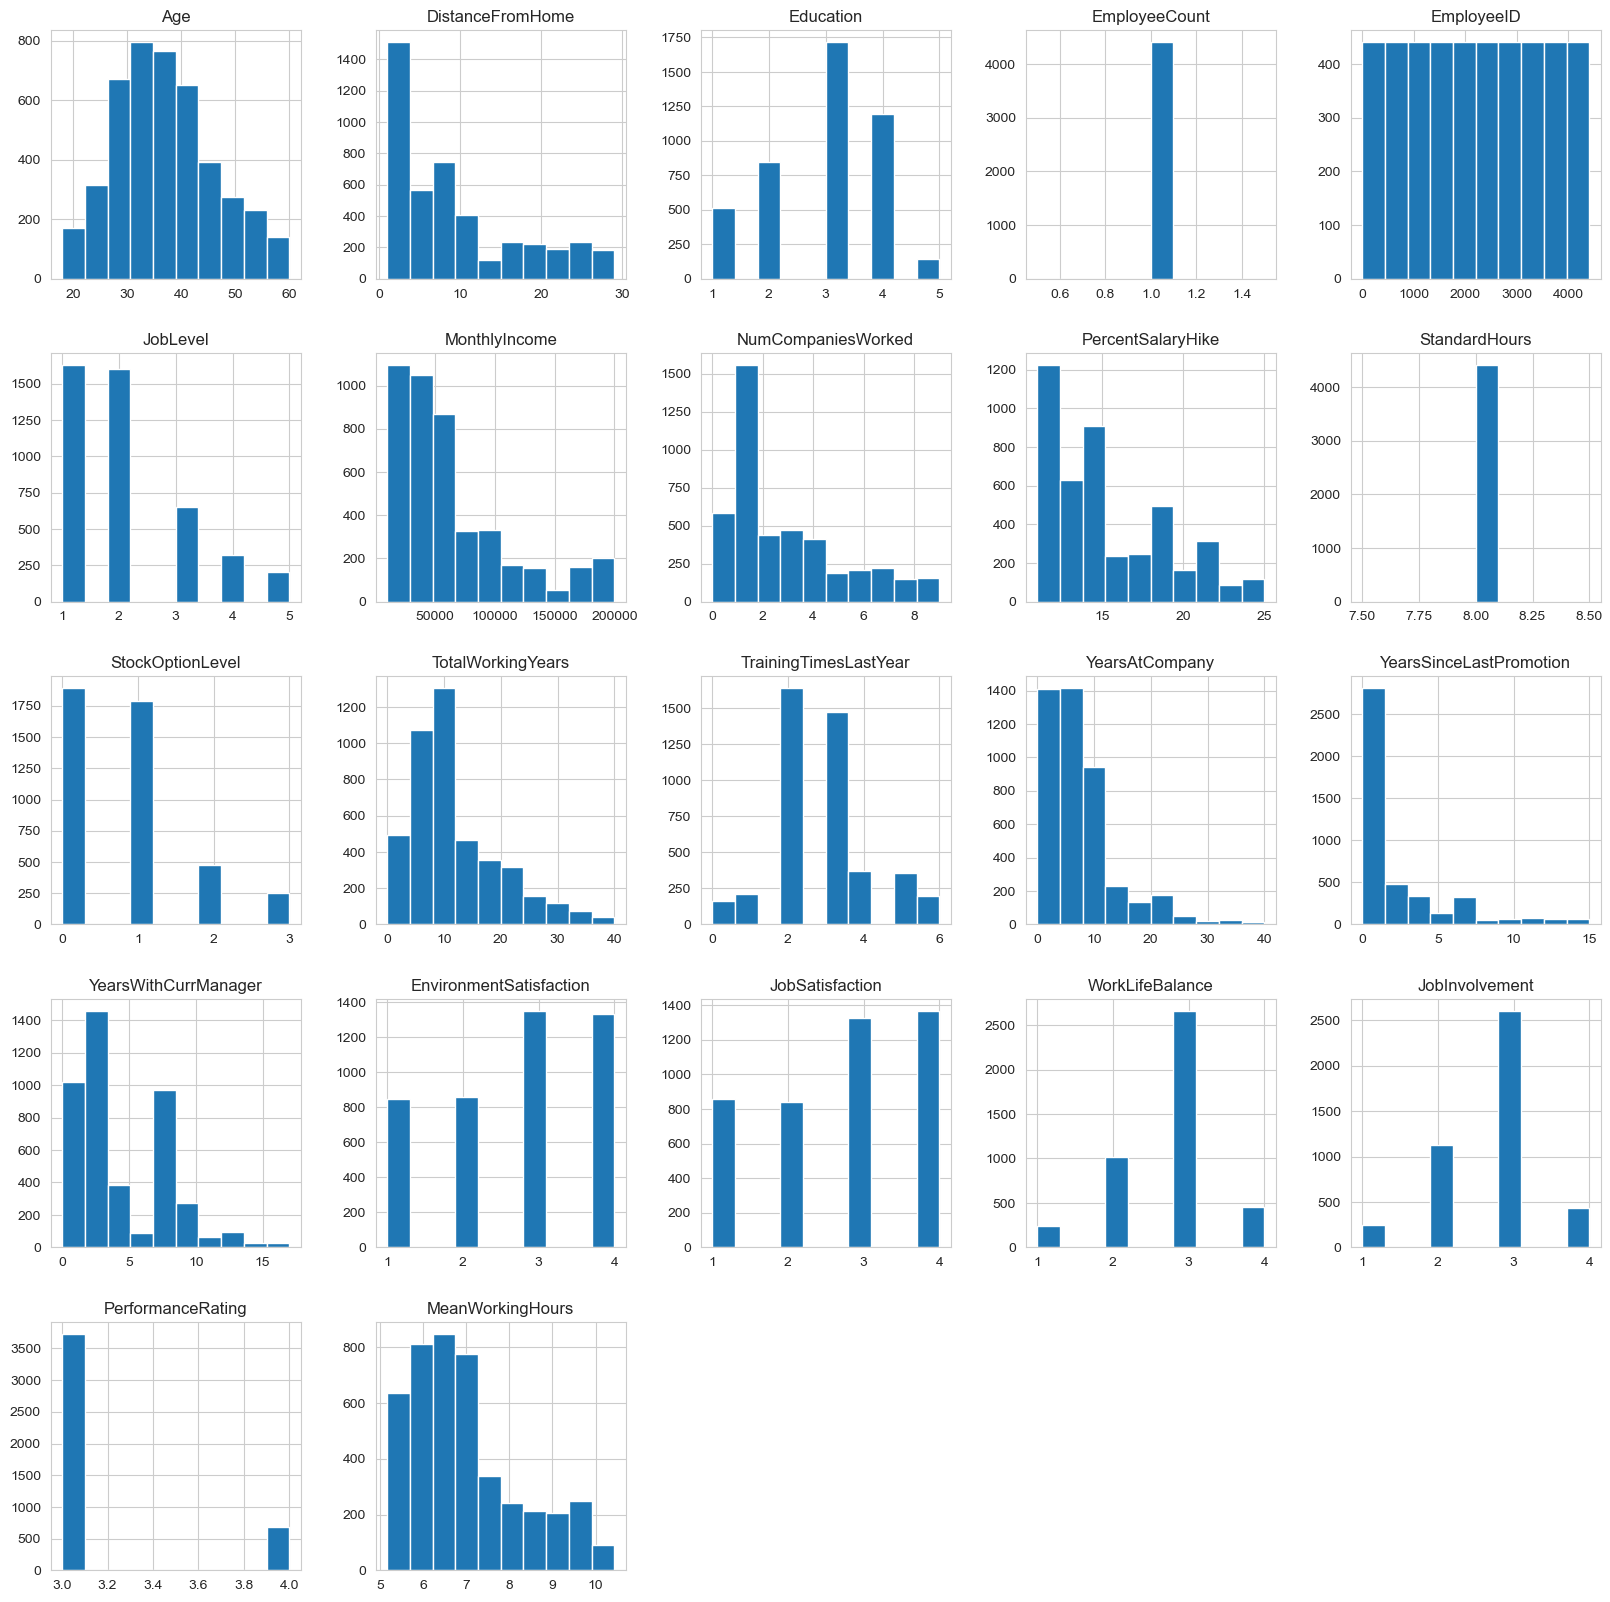

In [7]:
datas.hist(figsize=(20,20))
plt.show()

Nous avons remarqué que les colonnes "EmployeeCount" et "StandardHours" ont les mêmes valeurs pour toutes les lignes, nous avons également remarqué que "EmployeeID" change pour chaque ligne donc ces colonnes peuvent être supprimées.

In [8]:
datas.drop(columns=["EmployeeCount","Over18","StandardHours"], errors="ignore", inplace=True)
datas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeID               4410 non-null   int64  
 8   Gender                   4410 non-null   object 
 9   JobLevel                 4410 non-null   int64  
 10  JobRole                  4410 non-null   object 
 11  MaritalStatus            4410 non-null   object 
 12  MonthlyIncome            4410 non-null   int64  
 13  NumCompaniesWorked       4391 non-null   float64
 14  PercentSalaryHike       

Pour voir si les données sont complètes on affiche les boîtes à moustaches

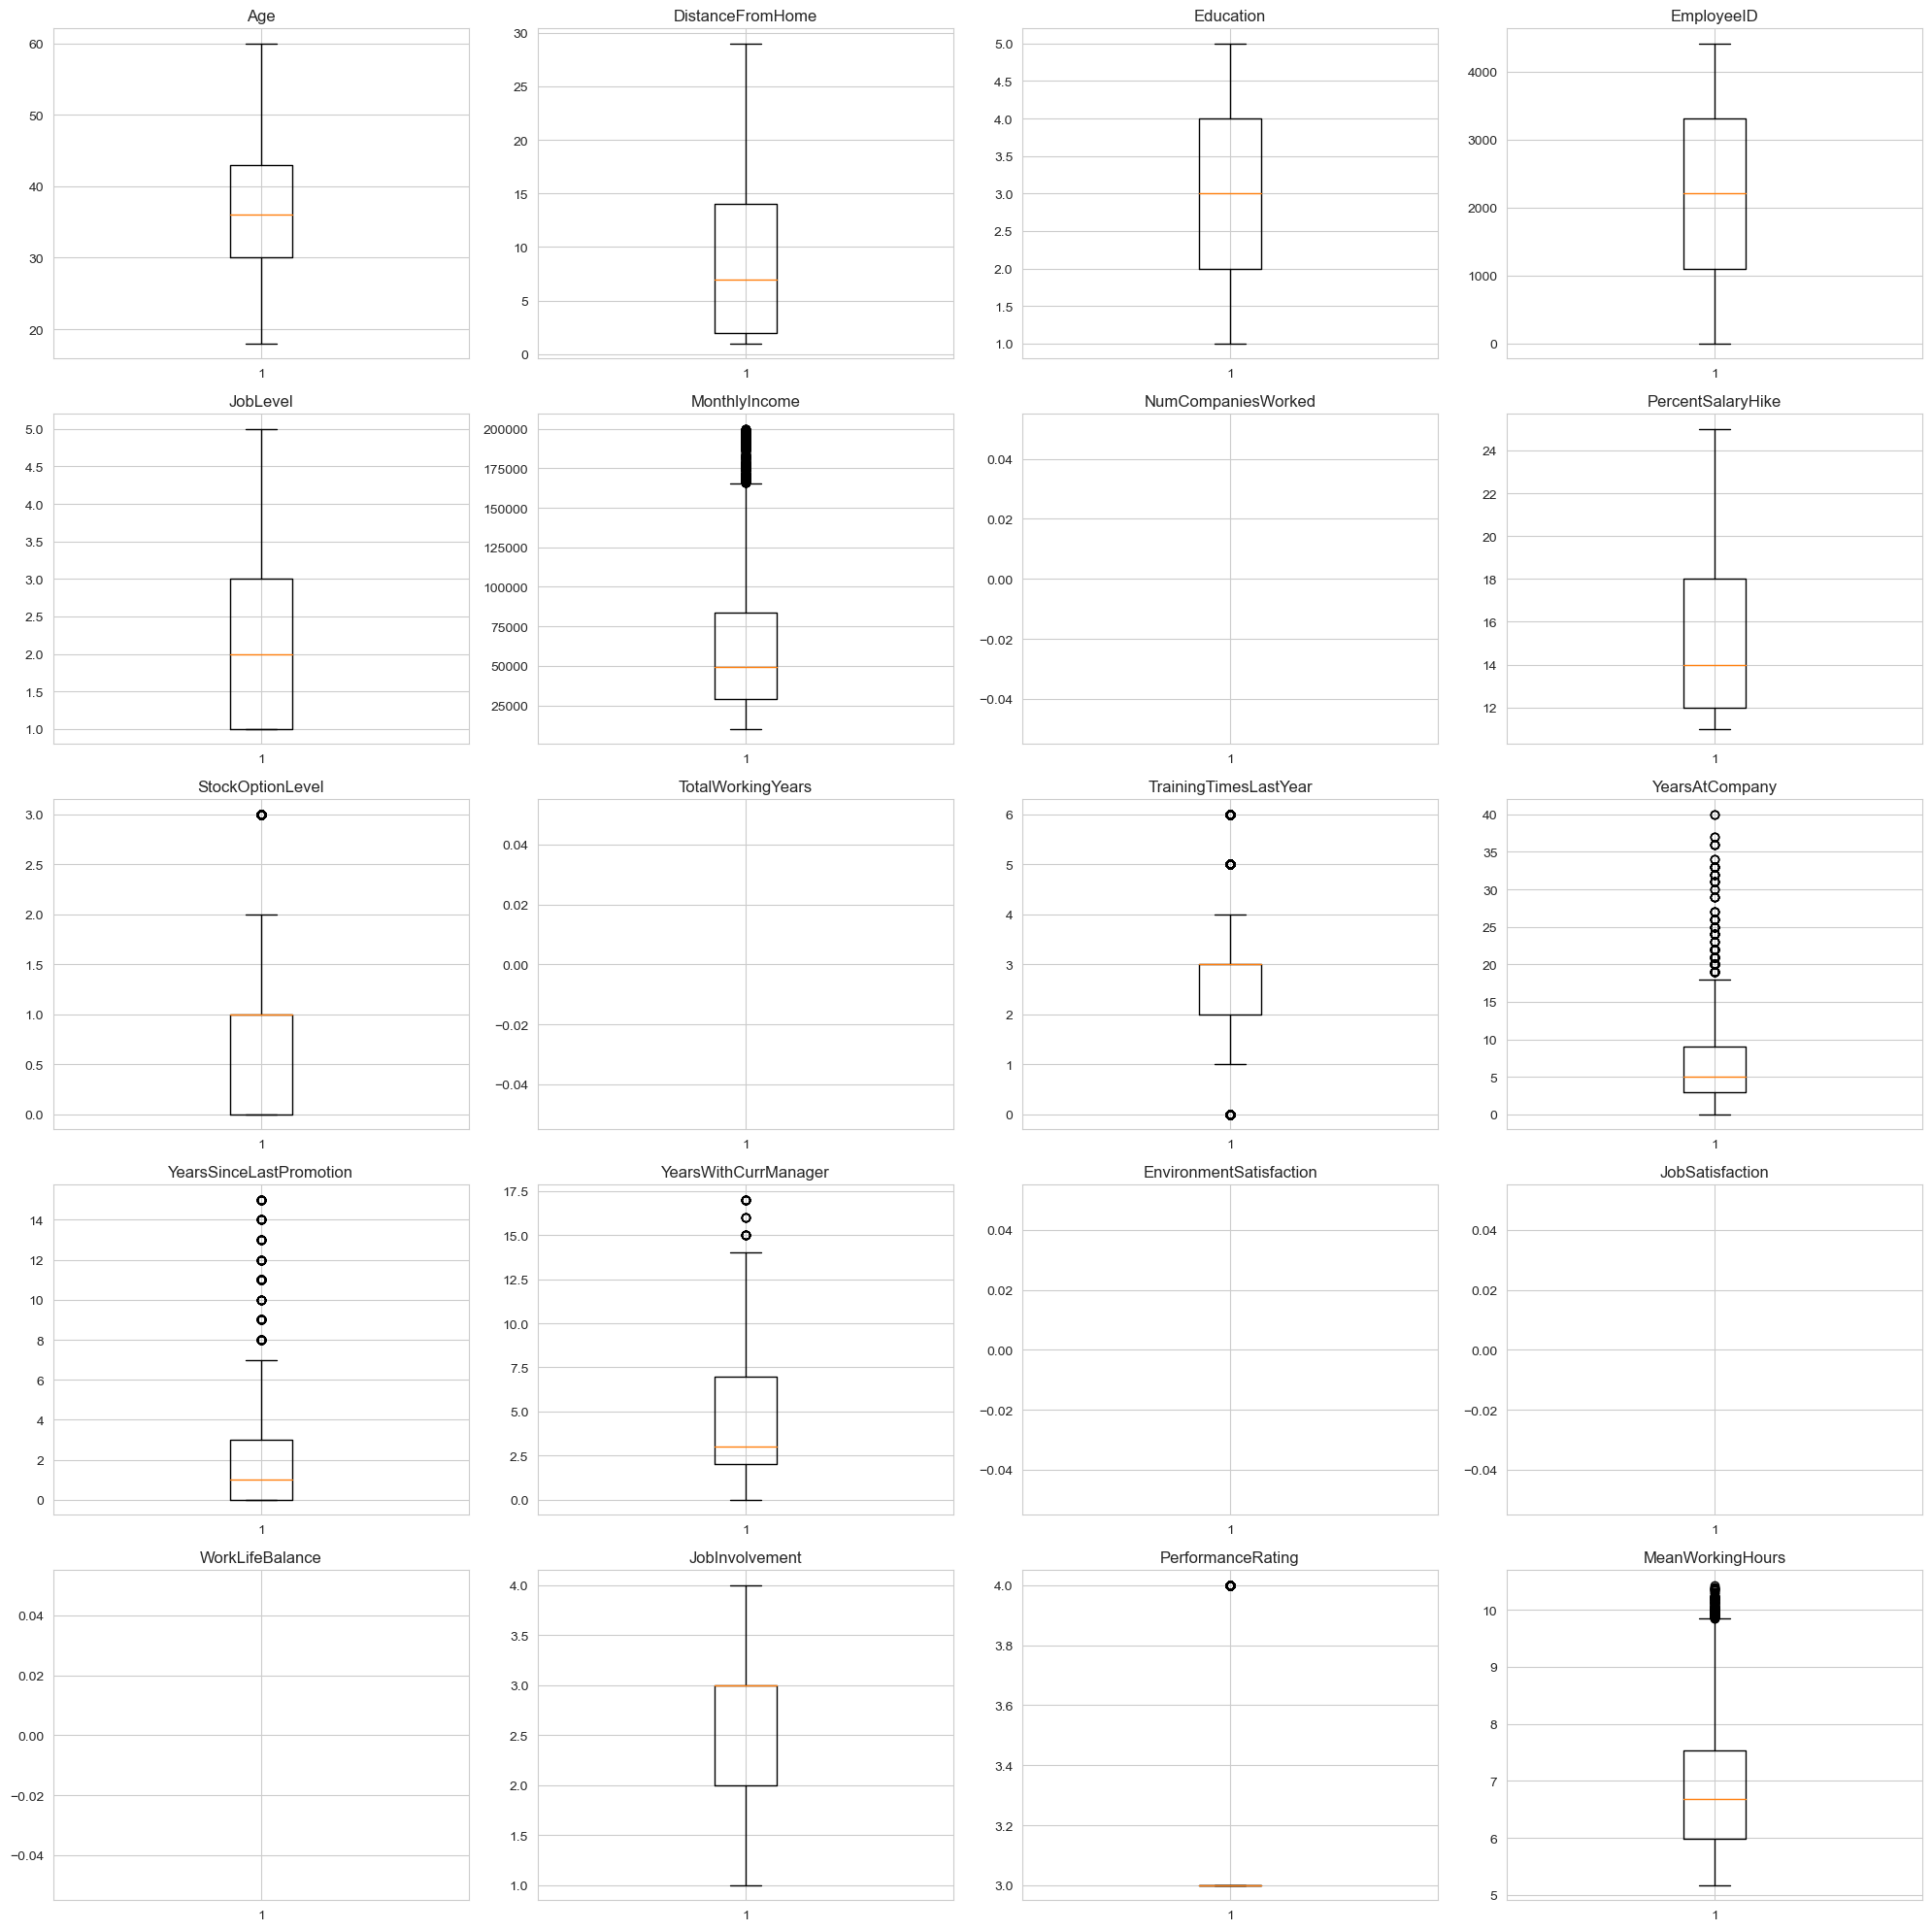

In [9]:
import math

numeric_cols = datas.select_dtypes(include=['float', 'int']).columns.tolist()

num_plots = len(numeric_cols)
num_cols = math.ceil(num_plots/5)
fig, axes = plt.subplots(nrows=5, ncols=num_cols, figsize=(20, 20))

for i, col in enumerate(numeric_cols):
    row_index = i // num_cols
    col_index = i % num_cols
    axes[row_index, col_index].boxplot(datas[col])
    axes[row_index, col_index].set_title(col)

plt.tight_layout()
plt.show()


On peut remarquer que pour certaines colonnes aucune case n'est affichée. La raison est que ces colonnes contiennent des valeurs manquantes. Nous les traiterons plus tard.

# Filtre Ethique
ici, on enleve les features ethiquement discutables. On a identifié:
- Age
- Gender
- MaritalStatus

In [10]:
datas.drop(columns=["Age","Gender","MaritalStatus"], axis=1, inplace=True, errors="ignore")
datas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Attrition                4410 non-null   object 
 1   BusinessTravel           4410 non-null   object 
 2   Department               4410 non-null   object 
 3   DistanceFromHome         4410 non-null   int64  
 4   Education                4410 non-null   int64  
 5   EducationField           4410 non-null   object 
 6   EmployeeID               4410 non-null   int64  
 7   JobLevel                 4410 non-null   int64  
 8   JobRole                  4410 non-null   object 
 9   MonthlyIncome            4410 non-null   int64  
 10  NumCompaniesWorked       4391 non-null   float64
 11  PercentSalaryHike        4410 non-null   int64  
 12  StockOptionLevel         4410 non-null   int64  
 13  TotalWorkingYears        4401 non-null   float64
 14  TrainingTimesLastYear   

In [11]:
#import numpy as np
from sklearn.preprocessing import OrdinalEncoder


mapping_dict = {'Non-Travel': 1, 'Travel_Rarely': 2, 'Travel_Frequently': 3}

datas['BusinessTravel'] = datas['BusinessTravel'].map(mapping_dict)


# encoder.fit()

In [12]:
mapping_dict = {'No': 0, 'Yes': 1}
datas['Attrition'] = datas['Attrition'].map(mapping_dict)

datas

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,JobLevel,JobRole,MonthlyIncome,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,MeanWorkingHours
0,0,2,Sales,6,2,Life Sciences,1,1,Healthcare Representative,131160,...,6,1,0,0,3.0,4.0,2.0,3,3,6.554356
1,1,3,Research & Development,10,1,Life Sciences,2,1,Research Scientist,41890,...,3,5,1,4,3.0,2.0,4.0,2,4,6.979604
2,0,3,Research & Development,17,4,Other,3,4,Sales Executive,193280,...,2,5,0,3,2.0,2.0,1.0,3,3,6.502698
3,0,1,Research & Development,2,5,Life Sciences,4,3,Human Resources,83210,...,5,8,7,5,4.0,4.0,3.0,2,3,6.477067
4,0,2,Research & Development,10,1,Medical,5,1,Sales Executive,23420,...,2,6,0,4,4.0,1.0,3.0,3,3,7.515375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,0,2,Research & Development,5,4,Medical,4406,1,Research Scientist,60290,...,5,3,0,2,4.0,1.0,3.0,3,3,7.934534
4406,0,2,Research & Development,2,4,Medical,4407,1,Laboratory Technician,26790,...,2,3,0,2,4.0,4.0,3.0,2,3,5.626061
4407,0,2,Research & Development,25,2,Life Sciences,4408,2,Sales Executive,37020,...,4,4,1,2,1.0,3.0,3.0,3,4,6.820812
4408,0,2,Sales,18,2,Medical,4409,1,Laboratory Technician,23980,...,2,9,7,8,4.0,1.0,3.0,2,3,8.765193


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Program

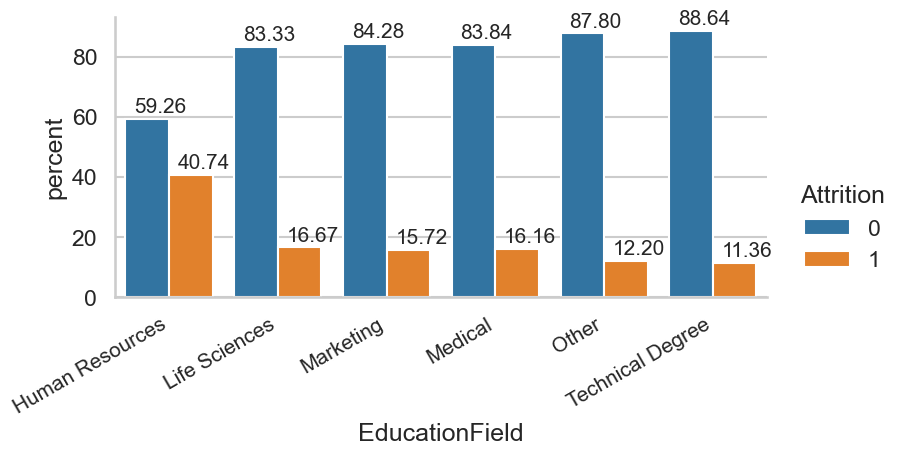

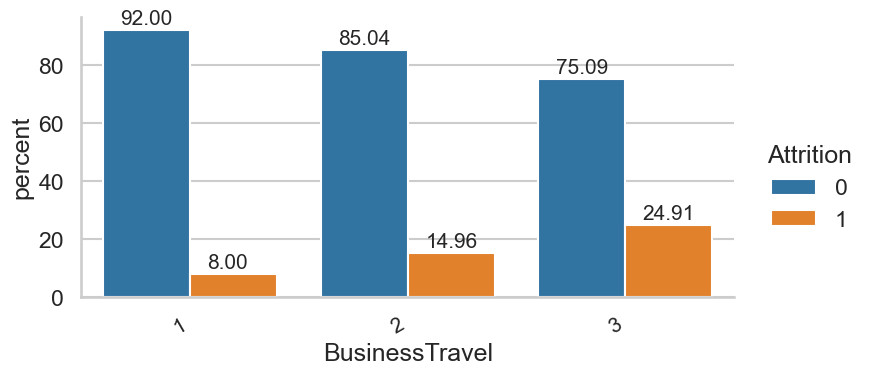

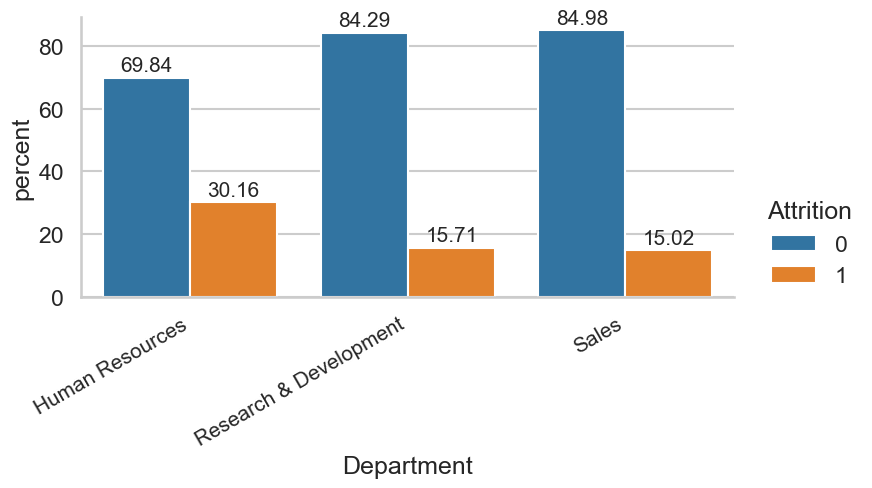

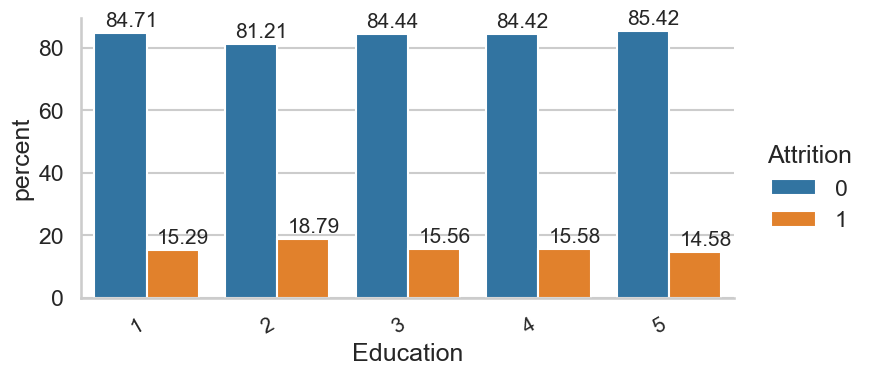

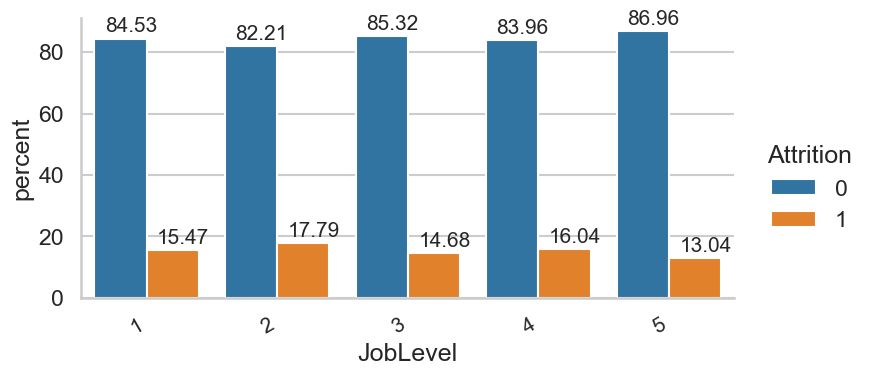

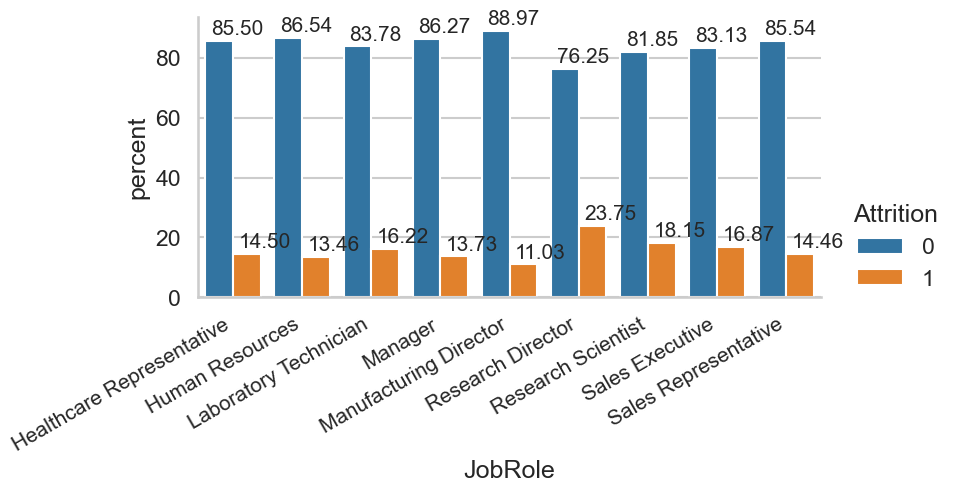

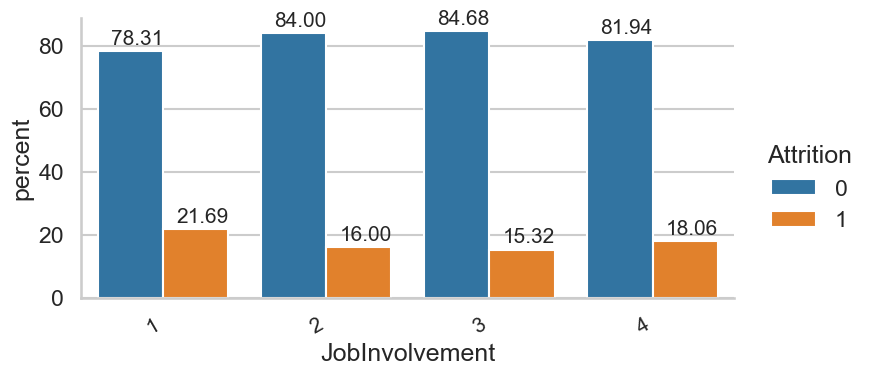

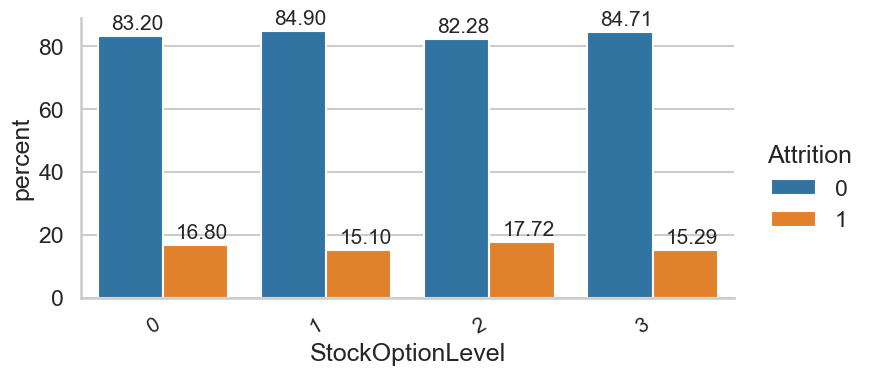

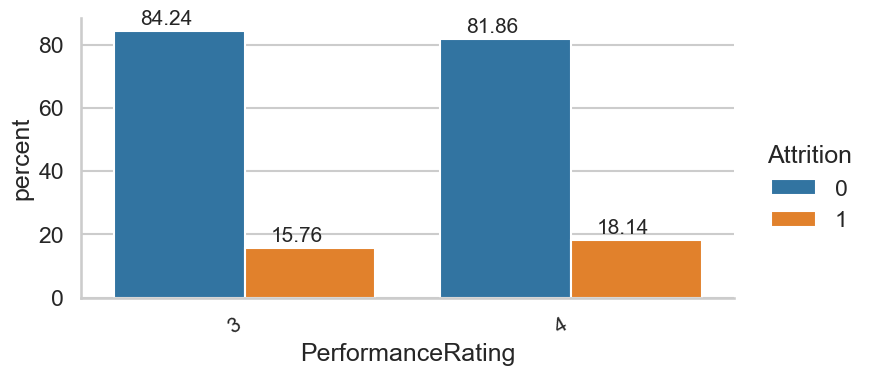

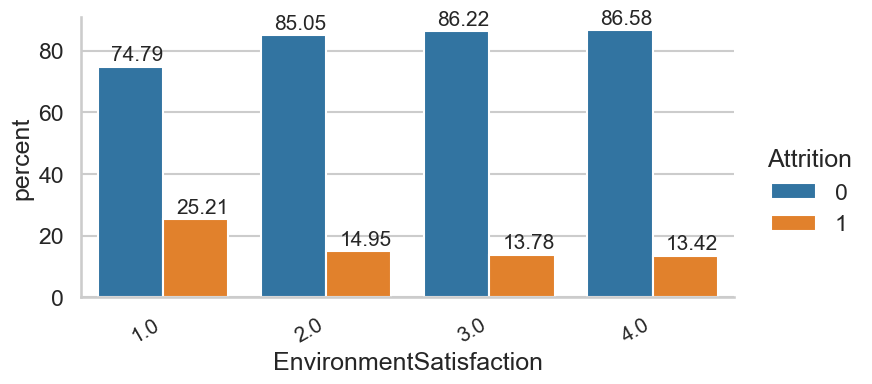

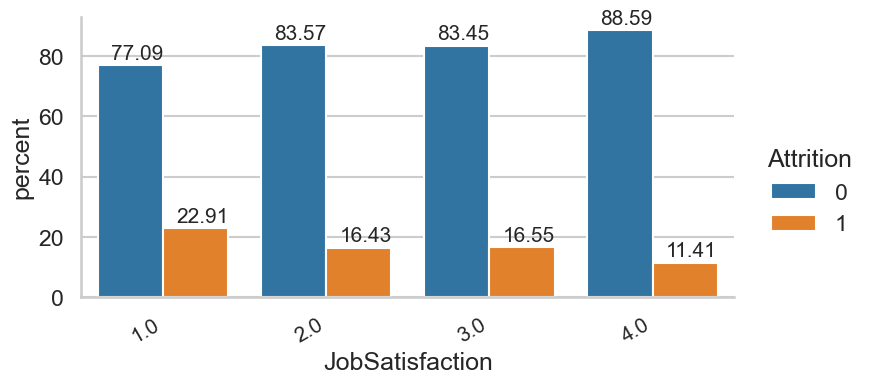

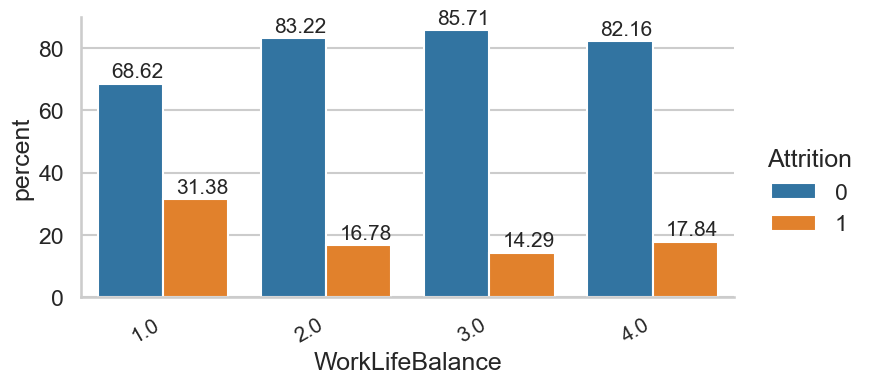

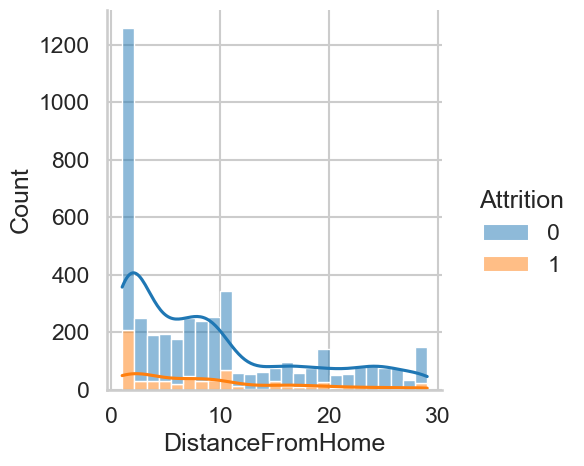

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


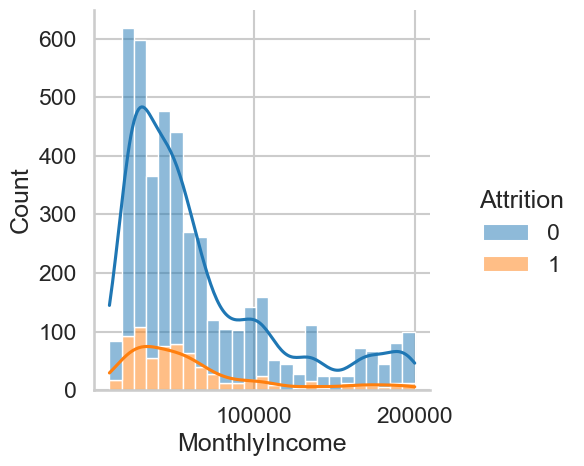

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


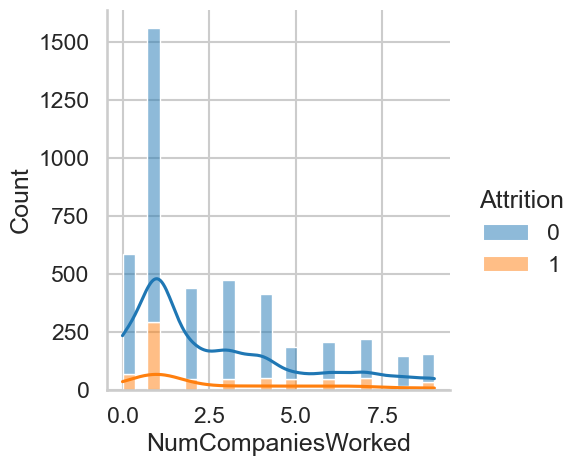

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


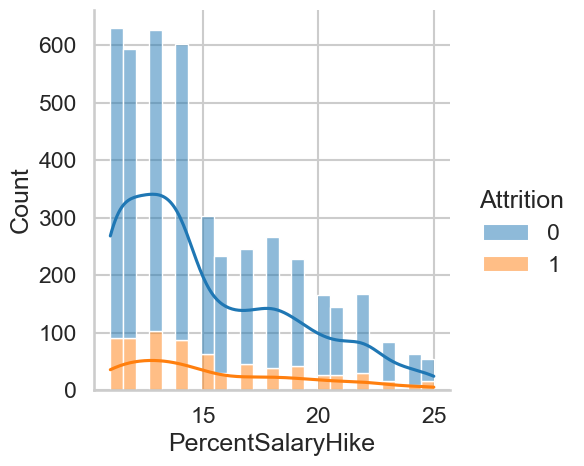

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


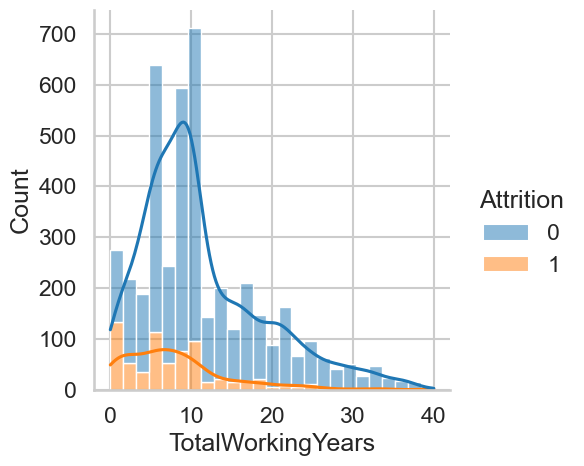

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


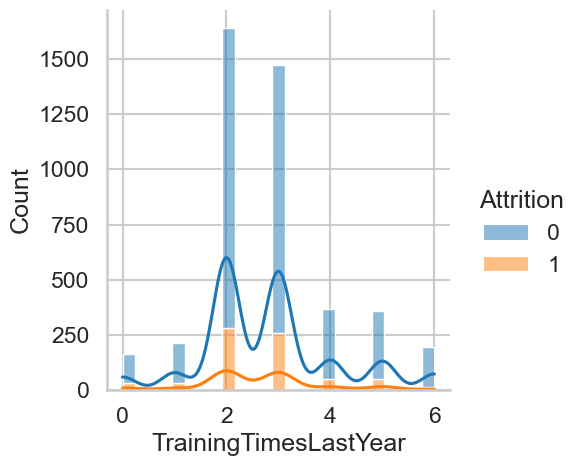

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


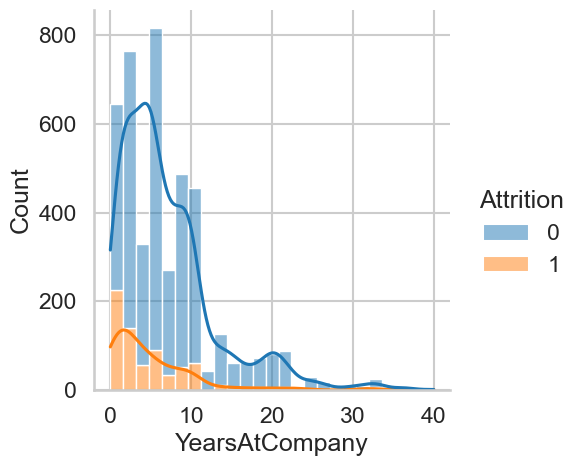

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


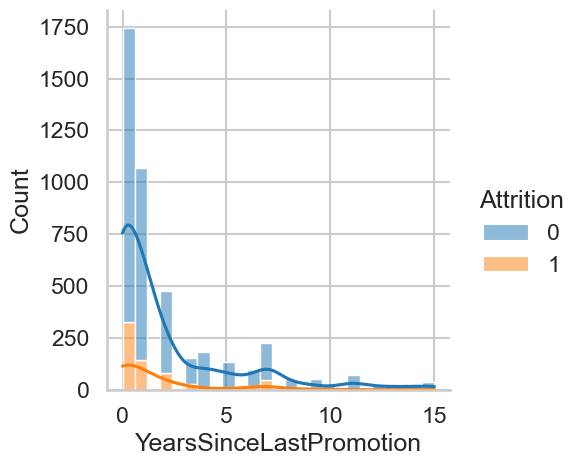

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


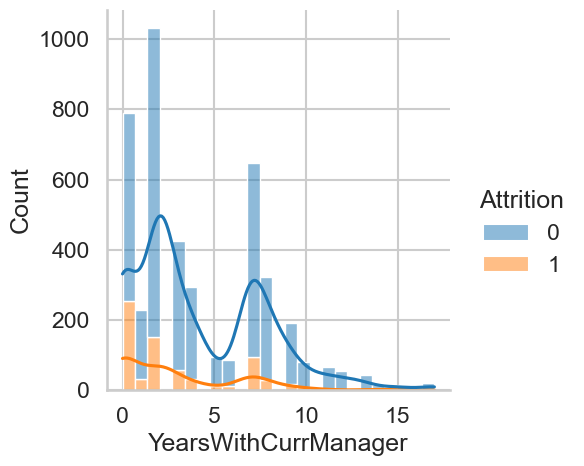

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


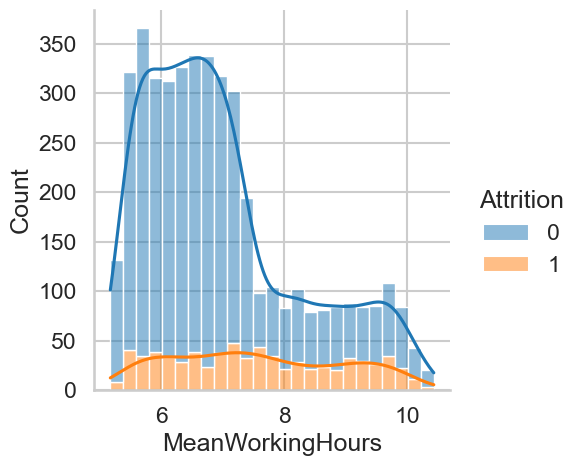

In [13]:
import seaborn as sns
def add_annotation(cat, c):
    x1 = c.get_x() + c.get_width() / 2 - .12
    y1 = c.get_y() + c.get_height() + 2

    cat.ax.annotate(format(c.get_height(), ".2f"), (x1, y1), size=15)

def plot_hist(column, df, annot=True):

    x_name = column
    y_name = 'Attrition'

    temp_data = (df
                 .groupby(x_name)[y_name]
                 .value_counts(normalize=True)
                 .mul(100)
                 .rename('percent')
                 .reset_index())

    sns.set_context('talk', font_scale = 1)
    catp = sns.catplot(data=temp_data, x=x_name, y='percent', hue='Attrition', kind='bar', height = 4, aspect = 2, legend_out=True, margin_titles=True)

    catp.set_xticklabels(rotation=30, fontsize=15, horizontalalignment='right',)



    if annot:
        spots = catp.ax.patches
        mid = len(spots) // 2

        for i in range(0, mid) :

            add_annotation(catp, spots[i])
            add_annotation(catp, spots[mid + i])

#To reduce size of output, we will display only valuable results, feel free to test for all by uncomment lines bellow.

discrete_columns = ['EducationField', 'BusinessTravel', 'Department', 'Education', 'JobLevel', 'JobRole', 'JobInvolvement', 'StockOptionLevel', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']
continue_colums = ['DistanceFromHome','MonthlyIncome','NumCompaniesWorked','PercentSalaryHike','TotalWorkingYears','TrainingTimesLastYear','YearsAtCompany','YearsSinceLastPromotion','YearsWithCurrManager','MeanWorkingHours']


for name in discrete_columns:
    plot_hist(name, datas)

for name in continue_colums:
    sns.displot(data=datas, x=name, hue="Attrition", multiple="stack", kde=True, bins=25)
    plt.show()

Avec toutes ces informations, nous pouvons tirer quelques conclusions :

* Le taux de démission est plus élevé dans le département RH que dans tout autre département.
* Plus les salariés voyagent, plus ils risquent de démissionner.
* Plus l'équilibre entre vie professionnelle et vie privée est mauvais, plus les employés sont susceptibles de démissionner.
* Le taux de démission est plus élevé pour les célibataires.
* Plus les employés travaillent longtemps chaque jour, plus ils sont susceptibles de démissionner.

Faisons maintenant des OneHotEncoders des données string restantes

In [14]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()
encoded_datas_array = one_hot_encoder.fit_transform(datas[[
    "EducationField", "Department", "JobRole",]]).toarray()
encoded_datas_labels = one_hot_encoder.categories_
encoded_datas_labels = np.hstack([
    ["EducationField_" + x for x in encoded_datas_labels[0]],
    ["Department_" + x for x in encoded_datas_labels[1]],
    ["JobRole_" + x for x in encoded_datas_labels[2]]
    ])
encoded_data = pd.DataFrame(encoded_datas_array, columns=encoded_datas_labels)
#encoded_data["EmployeeID"] = datas["EmployeeID"]


datas = datas.join(encoded_data)
datas.drop(['EducationField', 'Department', "JobRole"], axis=1, inplace=True, errors="ignore")
datas.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Attrition                          4410 non-null   int64  
 1   BusinessTravel                     4410 non-null   int64  
 2   DistanceFromHome                   4410 non-null   int64  
 3   Education                          4410 non-null   int64  
 4   EmployeeID                         4410 non-null   int64  
 5   JobLevel                           4410 non-null   int64  
 6   MonthlyIncome                      4410 non-null   int64  
 7   NumCompaniesWorked                 4391 non-null   float64
 8   PercentSalaryHike                  4410 non-null   int64  
 9   StockOptionLevel                   4410 non-null   int64  
 10  TotalWorkingYears                  4401 non-null   float64
 11  TrainingTimesLastYear              4410 non-null   int64

# Vérification d'exhaustivité
Dans un premier temps, on regarde les données pour voir s'il y a des features manquantes pour certaines instances.

In [15]:
datas = datas.dropna(subset=datas.columns)
datas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4300 entries, 0 to 4408
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Attrition                          4300 non-null   int64  
 1   BusinessTravel                     4300 non-null   int64  
 2   DistanceFromHome                   4300 non-null   int64  
 3   Education                          4300 non-null   int64  
 4   EmployeeID                         4300 non-null   int64  
 5   JobLevel                           4300 non-null   int64  
 6   MonthlyIncome                      4300 non-null   int64  
 7   NumCompaniesWorked                 4300 non-null   float64
 8   PercentSalaryHike                  4300 non-null   int64  
 9   StockOptionLevel                   4300 non-null   int64  
 10  TotalWorkingYears                  4300 non-null   float64
 11  TrainingTimesLastYear              4300 non-null   int64  
 1

# Scaling
Ici, nous allons mettre toutes nos valeurs sur la même échelle. 

In [16]:
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler().fit(datas)
datas_scaled = pd.DataFrame(std_scale.transform(datas), columns=datas.columns)

# Etude de corrélation

Nous utilisons une matrice de corrélation est simplement un tableau qui affiche les coefficients de corrélation pour différentes variables. La matrice représente la corrélation entre toutes les paires de valeurs possibles dans un tableau.

Dans la figure située juste en dessous de ce bloc, nous pouvons clairement voir des données hautement corrélées ; Cependant nous constatons une écrasante majorité de données non corrélées ! Mais nous devons d’abord abandonner les données textuelles traduites pour notre matrice de corrélation, car établir une corrélation uniquement sur des données descriptives qui n’ont aucune signification de valeur n’aurait aucun sens.


Attrition                            1.000000
MeanWorkingHours                     0.195102
BusinessTravel                       0.122725
EducationField_Human Resources       0.089159
Department_Human Resources           0.074338
JobRole_Research Director            0.044520
NumCompaniesWorked                   0.043911
PercentSalaryHike                    0.034425
JobRole_Research Scientist           0.030277
PerformanceRating                    0.026262
EducationField_Life Sciences         0.012283
JobRole_Sales Executive              0.011370
JobRole_Laboratory Technician       -0.000584
EmployeeID                          -0.001707
EducationField_Medical              -0.001983
EducationField_Marketing            -0.003655
StockOptionLevel                    -0.007971
JobRole_Sales Representative        -0.008109
DistanceFromHome                    -0.008314
JobRole_Human Resources             -0.013227
JobRole_Healthcare Representative   -0.013255
Department_Research & Development 

<Axes: >

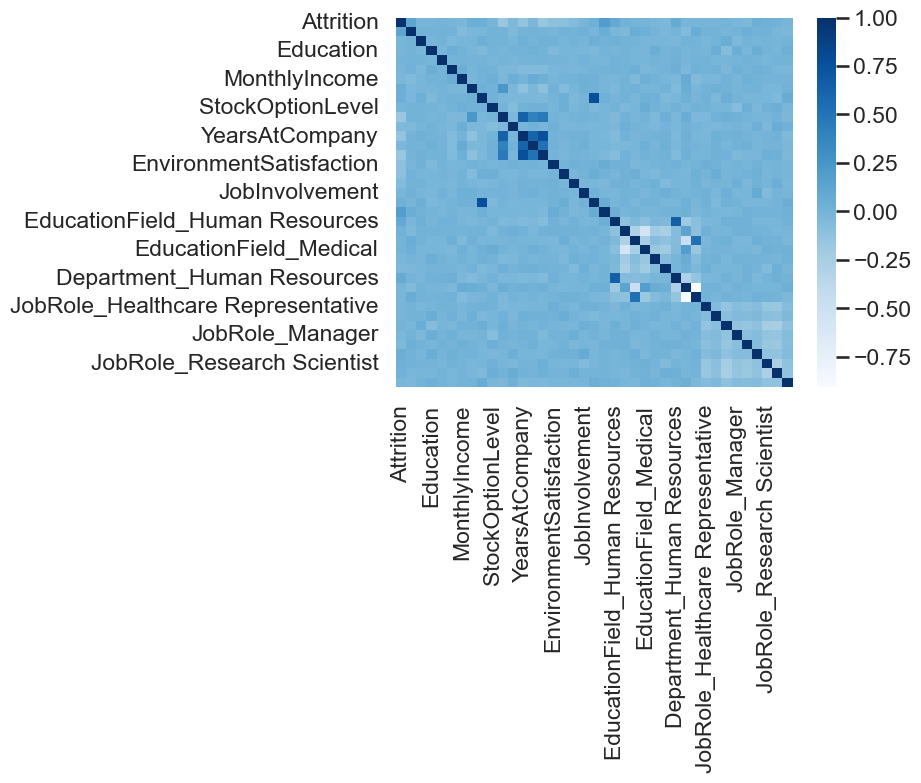

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

corr =datas_scaled.corr()
print(corr["Attrition"].sort_values(ascending=False))
sns.heatmap(corr, cmap=plt.cm.Blues)

<Axes: >

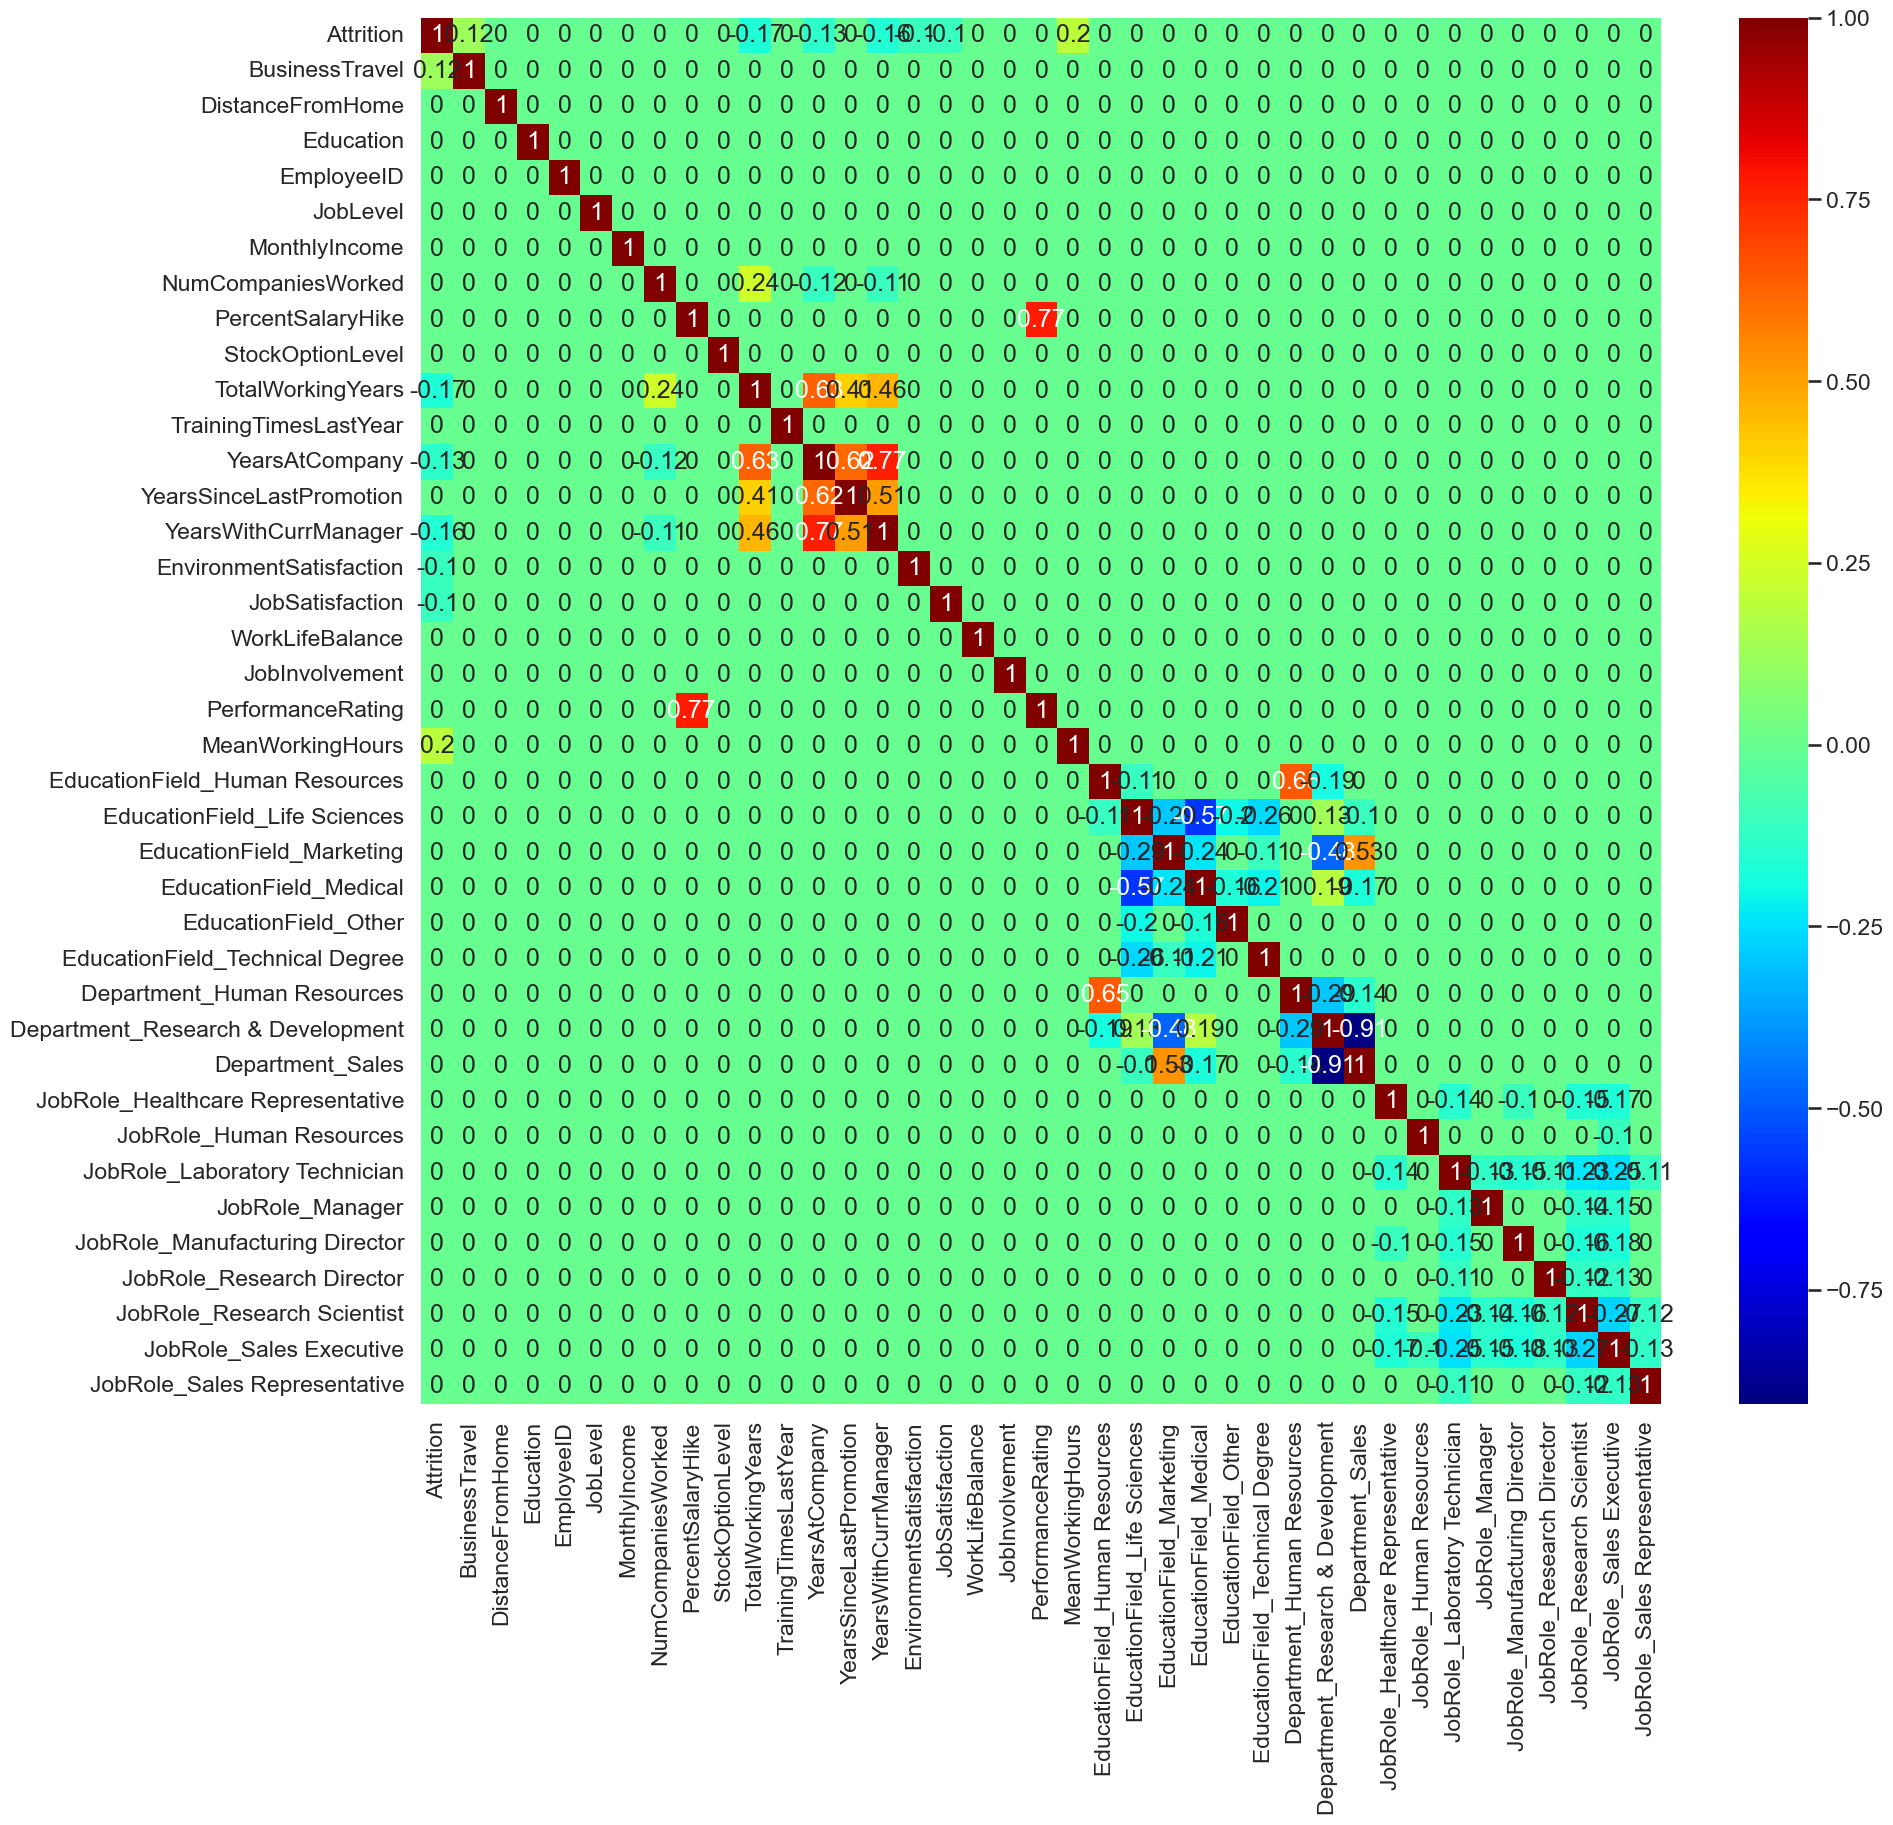

In [18]:
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        if abs(corr.iloc[i, j]) < 0.1:
            corr.iloc[i, j] = 0

plt.figure(figsize=(20,18))
sns.heatmap(corr, annot=True, cmap=plt.get_cmap("jet"))

Après analyse, nous prévoyons de garder:
- MeanWorkingHours
- BusinessTravel
- EducationField_Human Resources
- WorkLifeBalance
- JobSatisfaction
- EnvironmentSatisfaction
- YearsAtCompany
- YearsWithCurrManager
- TotalWorkingYears


Avant de continuer, mettons nos données dans un nouveau CSV (dans le cas ou on veut recharger nos données directement nettoyées).

In [19]:
datas_scaled.drop("Attrition", axis=1, inplace=True, errors="ignore")
datas_scaled.drop("EmployeeID", axis=1, inplace=True, errors="ignore")
datas_scaled.to_csv('datas/cleanedData.csv', index=False)

In [20]:
datas["Attrition"].to_csv('datas/labels.csv', index=False)

# Création du jeu d'entrainement et de test

In [21]:
import pandas as pd 
cleaned_datas = pd.read_csv("datas/cleanedData.csv")
labels = pd.read_csv("datas/labels.csv")

Creation de la fonction:

In [22]:
from sklearn.model_selection import train_test_split

def train_test_creation(x:pd.DataFrame,y:pd.DataFrame, features=[], test_size=0.3):
    """
    Pour appeler la fonction:
    X_train, X_test, y_train, y_test = train_test_creation(datas.drop(columns="label"), datas["label"])

    Pour appeler la fonction en precisant les features:
    X_train, X_test, y_train, y_test = train_test_creation(datas.drop(columns="label"), datas["label"], features=["feature1","feature2","..."])

    Pour appeler la fonction en précisant le test_size:
    X_train, X_test, y_train, y_test = train_test_creation(datas.drop(columns="label"), datas["label"], test_size=0.2)

    """
    # X_train, X_test, y_train, y_test = None
    if(len(features)==0):
        X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=test_size, shuffle=True, random_state=42)
    else:
        X_train, X_test, y_train, y_test = train_test_split( x[features], y, test_size=test_size, shuffle=True)
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()

    return X_train, X_test, y_train, y_test




appel de la fonction:

In [23]:
X_train, X_test, y_train, y_test = train_test_creation(cleaned_datas, labels["Attrition"], features=["MeanWorkingHours", "BusinessTravel", "EducationField_Human Resources", "WorkLifeBalance", "JobSatisfaction", "EnvironmentSatisfaction", "YearsAtCompany", "YearsWithCurrManager", "TotalWorkingYears"])

# Selection des modèles
## Description des modèles comparés
Nous avons choisi 5 Modèles de classification supervisées disponibles dans la bibliothèque scikit-learn.

- Decision Tree
- Random Forest
- SGD Classifier (Stochastique Gradient Classifier)
- Perceptron
- SVC

### Decision Tree
Le Decision Tree est un algorithme se basant sur un arbre tel que celui sur le graph ci-dessous

<img src="./images/Decision-Tree.png">

Chacun des noeuds est un noeud de décision. a travers chacuns d'eux il y a une embranchement basé sur la valeur d'une feature.

On détermine la feature de chaque embranchement avec l'Information Gain:

$$Entropy(S) = -\sum_{c\in c}{p(c)log_2p(c)} $$
$$ Information\ Gain(S,a) = Entropy(S) - \sum_{v\in values(a)}{\frac{|S_v|}{|S|}Entropy(S_v)}$$

avec:
- S est le data set sur lequel l'entropie est calculé
- c représente les classes dans le set S
- p(c), la proportion de points qui appartiennent a c sur le nombre total de points dans S
- a représente une feature spécifique
- |Sv|/ |S| représente la proportion de valeurs dans $S_v$ sur le nombre total de valeurs dans S

Pour choisir quelle feature prioriser dans l'arbre, on va séléctionner celle avec l'Information Gain le plus grand.

On aura en leaf node nos prédictions.

### Random Forest

Le Random Forest est un algorithme qui va multiplier les Decision Tree(Partie précédente). Chaque arbre est entrainé de manière indépendante.

### SGD Classifier
Le SGD Classifier (Stochastic Gradient Descend Classifier) est un algorithme de classification linéaire. Il a le même comportement qu'une descente de gradient classique, seulement, a chaque test, seulement un échantillon du dataset est considéré (points choisis aléatoirement dans des cluster).

Ensuite on fait varier nos paramètres en descendant le gradient pour minimiser notre erreur (on prendra l'erreur quadratique).

Prendre des échantillons aléatoire a chaque itérations peut également nous permettre plus d'exploration afin de sortir d'un minimum local.


### Perceptron
Voici un schéma de perceptron:

<img src="./images/X.png">

Ici:
- X représente nos entrées ($X_1$,$X_2$, ..., $X_n$)
- Ŷ représente notre sortie, notre prédiction.
- les $\omega$ ($\omega_1$,$\omega_2$, ..., $\omega_n$) représentent les poids a faire varier.

Avec ces données, voici la fonction F(X) q'utilisera notre perceptron:

$$ F(X) = ŷ = s \begin{pmatrix}\sum_{i=1}^n{(\omega_ix_i)+\omega_0}\end{pmatrix}$$


s représente notre fonction d'activation.
Etant en classification, notre fonction d'activation sera une fonction sigmoïde.

Ainsi: 
$$ F(X) = ŷ = \frac{1}{1+e^{\begin{pmatrix}\sum_{i=1}^n{(\omega_ix_i)+\omega_0}\end{pmatrix}}} $$


**Apprentissage**:
Pour apprendre il nous faut donc faire varier notre $w$ au fil des itérations. Nous allons utiliser pour cela la descente de gradient:

$$\omega _i^{t+1} = \omega_i^t-\eta\frac{\delta erreur}{\delta \omega _i^t}\\
\ \\
erreur(y_t,ŷ_t) = -y_t-log(ŷ_t)-(1--y_t-log(ŷ_t))\\
\ \\
donc\ \omega _i^{t+1} = \omega_i^t-\eta\frac{\delta (-y_t-log(ŷ_t)-(1--y_t-log(ŷ_t)))}{\delta \omega _i^t}$$

Pour l'erreur, on prend une entropie croisée étant en classification. On aurait pris une erreur quadratique pour de la regression.

$\eta$ représente notre learning rate, c'est la "vitesse d'apprentissage".

Le but va être au fil des itération, de minimiser nos erreurs et de maximiser nos prédictions.

### SVC
Le SVC est un classifieur basé sur le SVM. Voici comment fonctionne le SVM:
l'objectif est de séparer nos classes par un hyperplan comme sur l'image ci-dessous:

<img src="./images/svm.png" style="background:White">

On se place  dans le cas où le problème est linéairement séparable. Même dans ce cas simple, le choix de l'hyperplan séparateur n'est pas évident. Il existe en effet une infinité d'hyperplans séparateurs. On le voit bien en deux dimensions comme montré dans la figure ci-dessous : on continue à séparer les points positifs des points négatifs si on bouge et tourne un peu une droite qui les séparait déjà. Toutes ces hyperplans séparateurs ont les performances en apprentissage sont identiques (le risque empirique est le même), mais les performances en généralisation peuvent être très différentes.
Pour résoudre ce problème, il a été montré par Vapnik et Kotz en 198211, qu'il existe un unique hyperplan optimal. Il est défini comme l'hyperplan qui maximise la marge entre les échantillons et l'hyperplan séparateur. On veut que l'hyperplan choisi (par exemple la droite en deux dimensions) soit la plus loin des points. Il existe des raisons théoriques à ce choix. Vapnik et Kotz ont montré que la capacité des classes d'hyperplans séparateurs diminue lorsque leur marge augmente.

L'hyperplan est paramétré par les poids $\omega$ et $\omega_0$, son équation est:
$$h(x) = \omega^Tx+\omega 0 = 0$$
Le but est de trouver les poids qui minimisent la marge. l'hyperplan qui maximise cette marge est donc:
$$arg\ max_{\omega , \omega 0}\ min_k\ \{ ||x-x_k||: x \in \R^N, \omega^Tx+\omega_0=0 \}$$




## Entrainement

In [24]:
#imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC

#classifiers creation
svc_clf = SVC()
sgd_clf = SGDClassifier()
rf_clf = RandomForestClassifier()
Perceptron_clf = Perceptron()
tree_clf = DecisionTreeClassifier()

#training
svc_clf.fit(X_train,y_train)
sgd_clf.fit(X_train,y_train)
rf_clf.fit(X_train,y_train)
Perceptron_clf.fit(X_train,y_train)
tree_clf.fit(X_train,y_train)






DecisionTreeClassifier()

## Scoring, Indicateurs de performance

Les indicateurs que nous utiliserons afin de vérifier les performances de notre modèle final sont présentés dans cette partie. Ces notions
sont cruciales à comprendre et constituent ici une introduction à l'exploitation et l'interprétation finale de l'étude. Il est à noter que les
fonctions utilisent à la fois la bibliothèque scikit-learn (sklearn) mais également des fonctions réalisées sans l'utilisation de bibliothèque
spécifique afin de vérifier nos résultats et la bonne compréhension des métriques. Les indicateurs ci-dessous seront représentés avec
des valeurs servant d'exemples et de démonstrations.

### Matrice de confusion
La matrice est de confusion est aujourd'hui l'un des outils les plus utilisés pour évaluer les performances d'un modèle de classification.
Celle-ci présente un système de classes chacune associées à une valeur de représentation de cette classe suite à l'entrainement avec
un modèle de prédictions. Il est à noter que ce type de matrice fonctionne aussi bien pour des problèmes de classification à 2 classes
(binaires) ou plus.
Veuillez trouver ci-dessous un exemple de matrice de prédiction binaire :
<img src="./images/confusionm.png">
Comme présenté sur la figure, dans le cas binaire les classes sont :
TP (True Positive) : les valeurs prédites positives par le modèle et qui se trouvent être positives au final (bonne prédiction)
TN (True Negative) : les valeurs prédites négatives par le modèle et qui se trouvent être négatives au final (bonne prédiction)
FP (False Positive) : les valeurs prédites positives par le modèle et qui se trouvent être négatives au final (mauvaise prédiction)
FN (False Negative) : les valeurs prédites négatives par le modèle et qui se trouvent être positives au final (mauvaise prédiction)

### Métriques de performance ###
Une fois la matrice de confusion construite, les indicateurs peuvent maintenant se calculer. Ceux présentés dans cette partie sont ceux
considérés comme les plus utiles pour l'étude et qui seront abordés dans la dernière partie.

### Sensibilité, Recall, TPR : True Positive Rate
Cette métrique de performance représente le pourcentage d'employés quittant l'entreprise et étant bien détectés comme partant de
l'entreprise par le modèle.
$$ Recall = \frac{TP}{TP+FN}  $$

### Spécificité, TNR : True Negative Rate
Cette métrique de performance représente le pourcentage d'employés restant dans l'entreprise et donc les employés étant bien détéctés
comme restant dans l'entreprise.
$$ TNR= \frac{TN}{TN+FP}  $$

### Fall out, FPR : False Positive Rate
Cette métrique de performance représente le pourcentage d'employés quittant l'entreprise, mais étant détectés comme restant dans
l'entreprise.
$$ FPR= \frac{FP}{TN+FP}  $$

### FNR : False negative Rate
Cette métrique de performance représente le pourcentage d'employés restant dans l'entreprise, mais étant détectés comme quittant l'entreprise.
$$ FNR= \frac{FN}{FN+TP}  $$

### Précision, PPV : Positive Preditive Value
La valeur de prédiction positive représente le pourcentage de prédictions positives étant réellement correctes.
$$ Precision= \frac{TP}{TP+FP}  $$

### FDR : False Discovery Rate
Le taux de fausses découvertes représente le pourcentage de prédictions positives étant incorrectes.
$$ FDR= 1-PPV \frac{FP}{TP+FP}  $$

### NPV : Negative Predictive Value
La valeur de prédiction négative représente le pourcentage de prédictions négatives étant réellement correctes.
$$ NPV= \frac{TN}{TN+FN}  $$

### FOR : False Omission Rate
Le taux de fausses omissions représente le pourcentage de prédictions négatives étant incorrectes
$$ FOR= 1-NPV \frac{FN}{TN+FN}  $$

### Accuracy, ACC
La justesse représente le pourcentage de prédictions correctes sur le total des prédictions.
$$ Accuracy= \frac{TP+TN}{TP+TN+FP+FN}  $$

### F1-score
Le score F1 représente une évaluation de la performance de l'algorithme. Ce score est la moyenne harmonique de la précision et du
rappel (cf: image ci-dessous).
Lorsque deux modèles ont une précision élevée et un faible recall ou inversement, la comparaison peut être plus compliquée. C'est
pourquoi, dans ce type de situation, il est préférable d'utiliser le score F1 car il permet de mesurer ces deux paramètres simultanément.
$$ F1\ Score=2 \frac{Precision*Recall}{Precision+Recall}  $$

### Cross Validation
Lors de l'entrainement il faut tout d'abord observer la capacité de ces différents modèles à classifier cette décision et ainsi évaluer leur qualité. Pour entrainer au mieux ces modèles nous allons utiliser la stratégie de la validation croisée (Cross Validation, CV). Cette stratégie va nous permettre de proposer au modèle, différentes séparations de notre jeu de données afin de trouver la séparation (entre données d'entrainement et données de test), la plus performante.
<p align="center">
<img src="./images/cross.png" style = "margin:center">
</p>

In [25]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

#scoring
svc_clf_score = cross_val_predict(svc_clf,X_train, y_train, cv=4)
sgd_clf_score = cross_val_predict(sgd_clf,X_train, y_train, cv=4)
rf_clf_score = cross_val_predict(rf_clf,X_train, y_train, cv=4)
Perceptron_clf_score = cross_val_predict(Perceptron_clf,X_train, y_train, cv=4)
tree_clf_score = cross_val_predict(tree_clf,X_train, y_train, cv=4)

#Printing score
def print_score(y, s):
    """
    y: labels
    s: predictions
    """
    print(f"precision : {precision_score(y, s)}")
    print(f"recall : {recall_score(y, s)}")
    print(f"f1 : {f1_score(y, s)}")
    print("confusion matrix:")
    print(confusion_matrix(y, s))


print("SVC:")
print_score(y_train, svc_clf_score)
print("----------------------------------------------")
print("SGD Classifier:")
print_score(y_train, sgd_clf_score)
print("----------------------------------------------")
print("RANDOM FOREST:")
print_score(y_train, rf_clf_score)
print("----------------------------------------------")
print("PERCEPTRON:")
print_score(y_train, Perceptron_clf_score)
print("----------------------------------------------")
print("DECISION TREE:")
print_score(y_train, tree_clf_score)
print("----------------------------------------------")

SVC:
precision : 0.6694915254237288
recall : 0.15581854043392504
f1 : 0.2528
confusion matrix:
[[2464   39]
 [ 428   79]]
----------------------------------------------
SGD Classifier:
precision : 0.3445378151260504
recall : 0.08086785009861933
f1 : 0.13099041533546327
confusion matrix:
[[2425   78]
 [ 466   41]]
----------------------------------------------
RANDOM FOREST:
precision : 0.880184331797235
recall : 0.7534516765285996
f1 : 0.8119022316684378
confusion matrix:
[[2451   52]
 [ 125  382]]
----------------------------------------------
PERCEPTRON:
precision : 0.3172268907563025
recall : 0.2978303747534517
f1 : 0.3072227873855544
confusion matrix:
[[2178  325]
 [ 356  151]]
----------------------------------------------
DECISION TREE:
precision : 0.6588021778584392
recall : 0.7159763313609467
f1 : 0.6862003780718336
confusion matrix:
[[2315  188]
 [ 144  363]]
----------------------------------------------


### Courbe ROC
La courbe ROC est un autre moyen d'évaluer un classificateur binaire. Elle confronte le taux de vrai positif (TPR ou recall) au taux de
faux positif (FPR).

### AUC
Pour la courbe ROC, un grand taux de vrais positifs implique beaucoup de faux positifs. La diagonale en pointillée représente la courbe
ROC d'un classificateur aléatoire. Un classificateur idéal s'en écarte au maximum dans le coin supérieur gauche.
C'est pourquoi on utilise comme métrique de comparaison l'air sous la courbe ROC, nommé AUC, que l'on souhaite la plus proche
possible de 1.

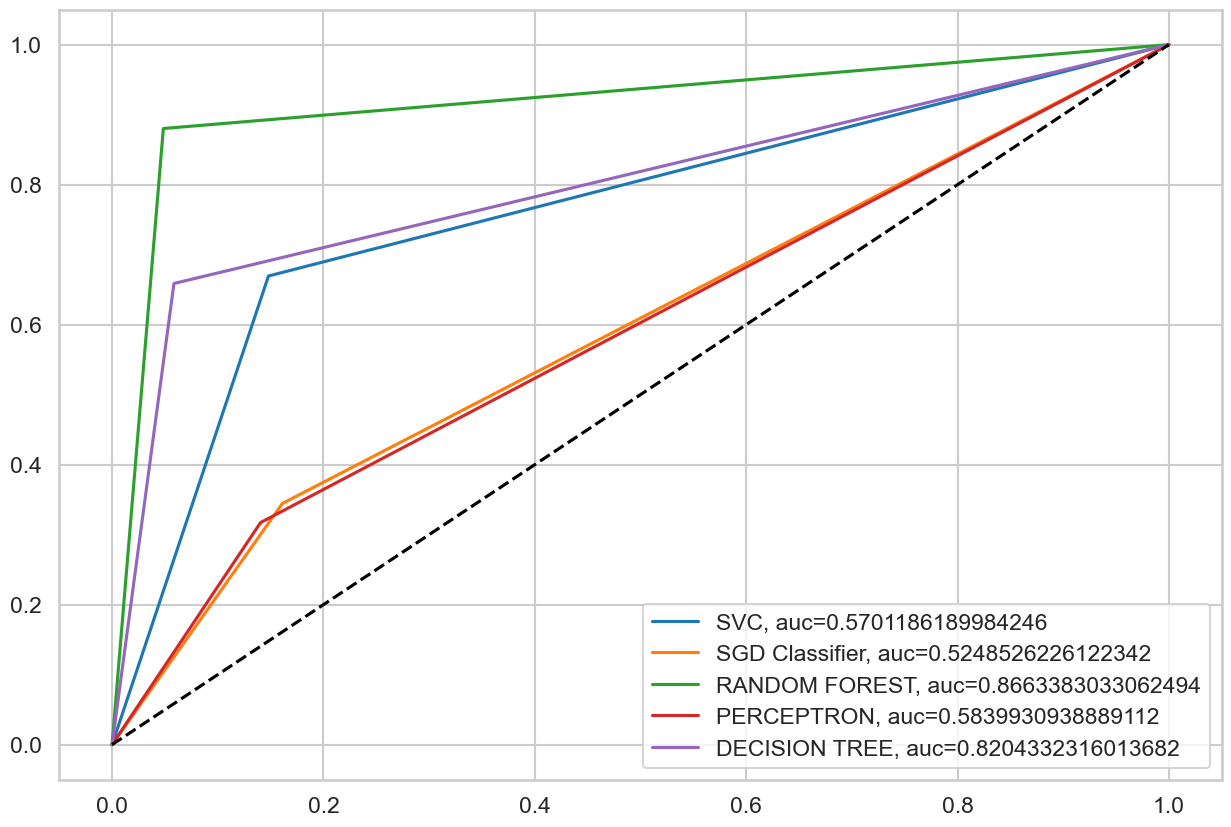

In [26]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.figure(0, figsize=(15,10)).clf()

def plot_roc(y, s, name:str):
    """
    y: labels
    s: predictions
    """
    fpr, tpr, thresh = metrics.roc_curve(s, y)
    auc = metrics.roc_auc_score(y, s)
    plt.plot(fpr,tpr,label=f"{name}, auc="+str(auc))

plot_roc(y_train, svc_clf_score,"SVC")
plot_roc(y_train, sgd_clf_score,"SGD Classifier")
plot_roc(y_train, rf_clf_score,"RANDOM FOREST")
plot_roc(y_train, Perceptron_clf_score,"PERCEPTRON")
plot_roc(y_train, tree_clf_score,"DECISION TREE")

plt.plot([0, 1], [0, 1], 'k--') #diagonale
plt.legend(loc=0)

En comparant nos AUC, nous avons choisis deux modèles pour aller plus loin:
- Random Forest
- Decision Tree

Dans la partie suivante, nous allons utiliser un grid search pour optimiser les hyperparamètres de nos modèles

# Fine Tuning

Ici, nous allons utiliser un grid search pour optimiser les hyperparamètres de nos modèles. L'objectif est donc de trouver les meilleurs hyperparamètres pour les deux modèles choisis.
### Hyperparamètres des modèles
L'objectif est de connaitre la valeur des hyperparamètres les plus pertinents en fonction des modèles appliqués à ce problème, certains d'entre eux sont utilisés presque partout, d'autres sont plus spécifiques à un modèle. Voici une définition de ceux que nous allons utiliser ainsi qu'une liste de valeur possible que nous appliquerons dans le code.
Chaque valeur a été choisie autour de la valeur par défaut fournie par les algorithmes, tout en respectant un certain pas d'une valeur à une autre d'un même hyperparamètre. Ces hyperparamètres seront testés et évalués par la suite grâce à la méthode GridSearchCV .
Cette méthode va aussi nous fournir les meilleurs hyperparamètres en fonction du meilleur score trouvé (le classement du score se fera en fonction de l'accuracy, cependant, tous les indicateurs seront calculés). GridSearchCV va nous permettre de tester l'ensemble des cas possibles pour toutes les valeurs d'hyperparamètre sur un modèle donné (les intervalles de valeurs pour les hyperparamètres sont relativement petits comme décrit ci-dessous et offre donc cette possibilité sans grandement influer sur les performances) :

<p align="center">
<img src=".\images\grid.png">
</p>

Les points bleus sur la figure représentent un entrainement du modèles avec les valeurs d'hyperparamètres correspondantes (tous les cas sont testés). Enfin, nous comparerons ces scores afin de déterminer le meilleur modèle.
### GridSearch
#### DecisionTreeClassifier
Il s'agit ici de faire varier deux hyperparamètres, splitter et max_features .
l'hyperparamètre splitter spécifie la stratégie utilisée pour choisir la méthode de fractionnement à chaque noeud. En plus d'agir sur la performance, celui-ci va permettre de fournir des résultats inédits (car l'aléatoire rentre en compte). Il prendra ainsi deux valeurs possibles qui sont les suivantes : 'best' et 'random'
l'hyperparamètre max_features spécifie le nombre maximal de critères qui vont être utilisés lors de la création de l'arbre. Le maximum (5) est représenté par le nombre de critères totaux dans le dataset. Celui-ci prendra les valeurs suivantes :
#### RandomForestClassifier
Ce modèle, quant à lui, va se voir faire varier trois hyperparamètres, n_estimators , max_features et bootstrap .
l'hyperparamètre n_estimators spécifie le nombre d'arbre dans la fôret, c'est à dire le nombre d'échantillons sur lesquels cet algorithme va travailler. Il prendra les valeurs suivantes : 100,200,300,400
l'hyperparamètre max_features est le même que pour le modèle "DecisionTreeClassifier"
l'hyperparamètre bootstrap spécifie si des échantillons seront utilisés lors de la construction des arbres. Sinon, l'ensemble des données est utilisé pour construire chaque arbre. Celui-ci prendra deux valeurs possibles : True et False

In [27]:
from sklearn.model_selection import GridSearchCV

depth_list = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, None]

tree_grid = [
    {'max_depth': depth_list, 'criterion': ['gini', 'entropy']}
  ]

forest_grid = [
    
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 9]},
    
    {'bootstrap': [False], 'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 9]},
  ]

forest_search = GridSearchCV(rf_clf, forest_grid, cv=10,
                           scoring='neg_mean_squared_error', return_train_score=True)
forest_search.fit(X_train, y_train)
tree_search = GridSearchCV(tree_clf, tree_grid, cv=10,
                           scoring='neg_mean_squared_error', return_train_score=True)
tree_search.fit(X_train, y_train)

print("random_forest:")
print(forest_search.best_params_)
print("decision_tree:")
print(tree_search.best_params_)


attributes = cleaned_datas[["MeanWorkingHours", "BusinessTravel", "EducationField_Human Resources", "WorkLifeBalance", "JobSatisfaction", "EnvironmentSatisfaction", "YearsAtCompany", "YearsWithCurrManager", "TotalWorkingYears"]].columns
feature_importances = forest_search.best_estimator_.feature_importances_
sorted(zip(feature_importances,attributes), reverse=True)
#X_train_df


random_forest:
{'bootstrap': False, 'max_features': 2, 'n_estimators': 30}
decision_tree:
{'criterion': 'entropy', 'max_depth': 40}


[(0.26572356251332185, 'MeanWorkingHours'),
 (0.1954465097025583, 'TotalWorkingYears'),
 (0.1384942274392555, 'YearsAtCompany'),
 (0.10352386752047167, 'YearsWithCurrManager'),
 (0.08351394470985408, 'JobSatisfaction'),
 (0.08089827500072264, 'EnvironmentSatisfaction'),
 (0.07171402723699931, 'WorkLifeBalance'),
 (0.04860413609048618, 'BusinessTravel'),
 (0.012081449786330465, 'EducationField_Human Resources')]

[Text(0, 0, ' 0.2657'),
 Text(0, 0, ' 0.1954'),
 Text(0, 0, ' 0.1385'),
 Text(0, 0, ' 0.1035'),
 Text(0, 0, ' 0.0835'),
 Text(0, 0, ' 0.0809'),
 Text(0, 0, ' 0.0717'),
 Text(0, 0, ' 0.0486'),
 Text(0, 0, ' 0.0121')]

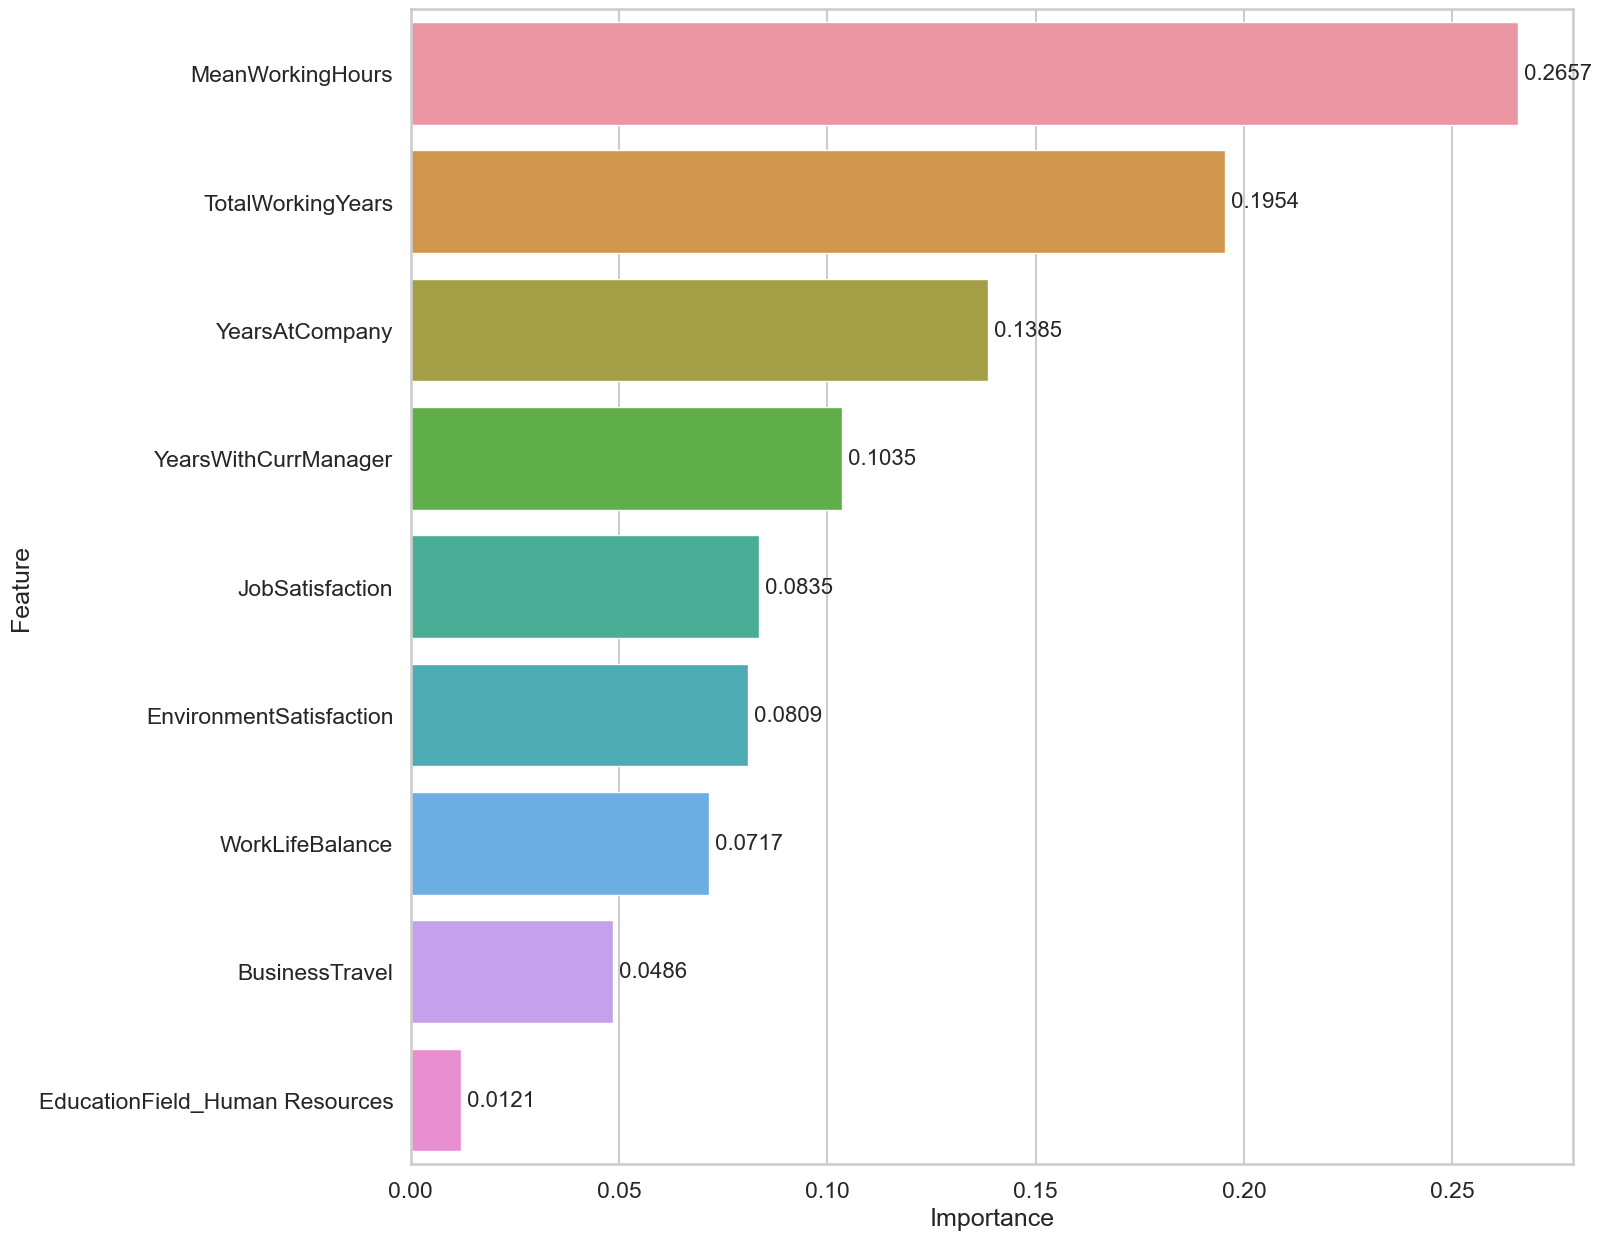

In [28]:
import pandas as pd
bests = {}
data = {
    'Feature': list(attributes),
    'Importance': list(feature_importances)
}
selector = pd.DataFrame(data)
selector = selector.sort_values(by='Importance', ascending=False)
selector


fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style='whitegrid', palette='magma', font_scale=1.5)
sns.barplot(y='Feature', x='Importance', data=selector, ax=ax)
ax.bar_label(ax.containers[-1], fmt=' %.4f', label_type='edge', fontsize=16)

Nous observons bien quels sont les features les plus importantes dans le RandomForestClasifier, abordées dans la conclusion.

Plus qu'a recréer des estimateur avec les bons paramètres:

DECISION TREE:
precision : 0.7562189054726368
recall : 0.8085106382978723
f1 : 0.781491002570694
confusion matrix:
[[1053   49]
 [  36  152]]
----------------------------------------------
RANDOM FOREST:
precision : 0.9491525423728814
recall : 0.8936170212765957
f1 : 0.9205479452054794
confusion matrix:
[[1093    9]
 [  20  168]]
----------------------------------------------


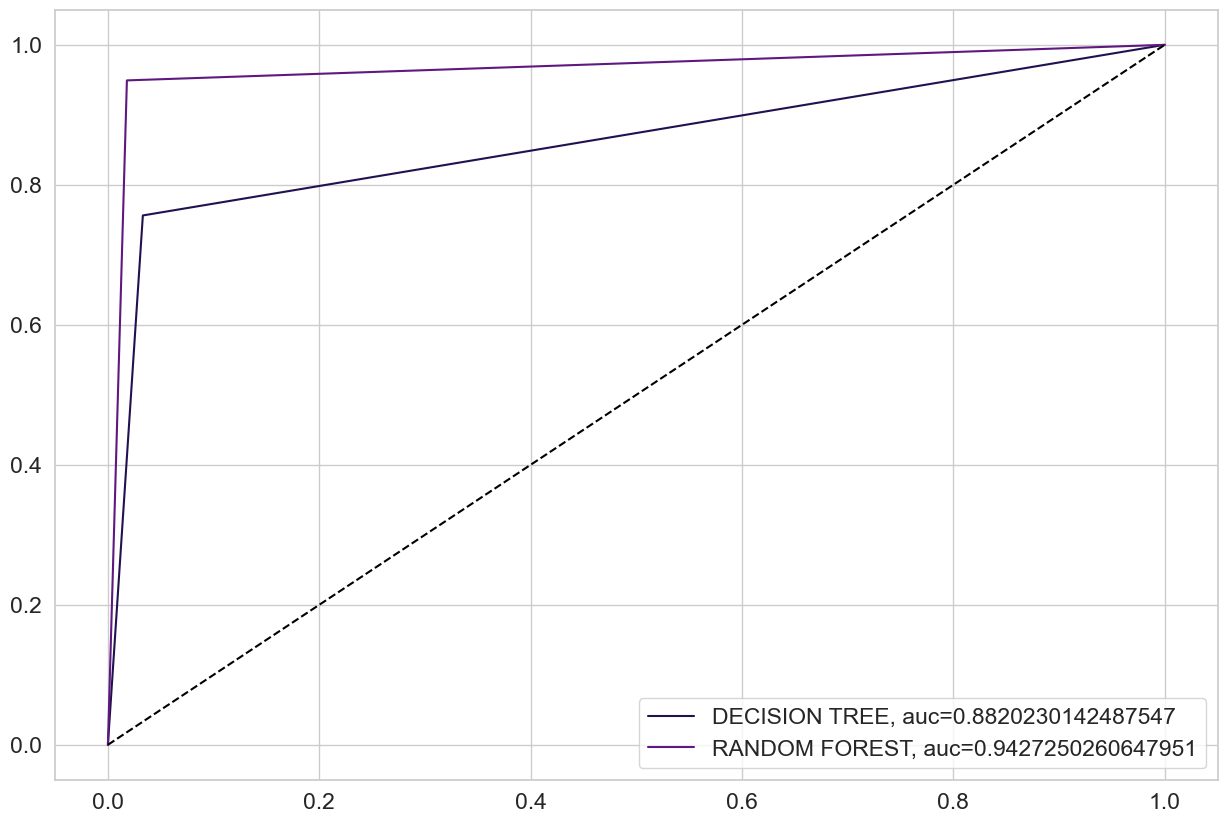

In [29]:
#init
tuned_decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=None)
tuned_rf = RandomForestClassifier(bootstrap=False, max_features=2, n_estimators=30)

#training
tuned_decision_tree.fit(X_train,y_train)
tuned_rf.fit(X_train,y_train)

#scoring
#opti_decision_tree_score = cross_val_predict(tuned_decision_tree,X_train, y_train, cv=10)
#opti_rf_score = cross_val_predict(tuned_rf,X_train, y_train, cv=10)

# opti_decision_tree_score = cross_val_predict(tuned_decision_tree,X_test, y_test, cv=4)
# opti_rf_score = cross_val_predict(tuned_rf,X_test, y_test, cv=4)

opti_decision_tree_score = tuned_decision_tree.predict(X_test)
opti_rf_score = tuned_rf.predict(X_test)

print("DECISION TREE:")
print_score(y_test, opti_decision_tree_score)
print("----------------------------------------------")
print("RANDOM FOREST:")
print_score(y_test, opti_rf_score)
print("----------------------------------------------")

plt.figure(0, figsize=(15,10)).clf()

plot_roc(y_test, opti_decision_tree_score,"DECISION TREE")
plot_roc(y_test, opti_rf_score,"RANDOM FOREST")

plt.plot([0, 1], [0, 1], 'k--') #diagonale
plt.legend(loc=0)

## Sauvegarde du Modèle 

In [30]:
import joblib
joblib.dump(tuned_rf,"tuned_rf.pkl")

['tuned_rf.pkl']

# Pipeline finale
Chargement des données

In [31]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

def load_data(file):
    return pd.read_csv(file)

path = "datas/"
general_data = load_data(path +"general_data.csv")
employee_survey_data = load_data(path +"employee_survey_data.csv")
manager_survey_data = load_data(path +"manager_survey_data.csv")
in_time = load_data(path +"in_time.csv")
out_time = load_data(path +"out_time.csv")

définition des fonctions et classes:

In [32]:
def print_score(y, s):
    """
    y: labels
    s: predictions
    """
    print(f"precision : {precision_score(y, s)}")
    print(f"recall : {recall_score(y, s)}")
    print(f"f1 : {f1_score(y, s)}")
    print("confusion matrix:")
    print(confusion_matrix(y, s))
    
def to_datetime(strdate):
    if type(strdate) == str:
        return datetime.strptime(strdate, "%Y-%m-%d %H:%M:%S").timestamp()
    else:
        return 0

def get_working_time(in_time_data, out_time_data):
    out_time_df = (
        out_time_data
        .iloc[:,1:]
        .applymap(lambda x: to_datetime(x))
    )
    in_time_df = (
        in_time_data
        .iloc[:,1:]
        .applymap(lambda x: to_datetime(x))
    )
    hours_per_day = out_time_df - in_time_df
    in_time_data["MeanWorkingHours"] = hours_per_day.mean(axis = 1)/3600
    return in_time_data[["EmployeeID", "MeanWorkingHours"]]


class MergeDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, employee_survey_data, manager_survey_data, in_time, out_time):
        self.employee_survey_data = employee_survey_data
        self.manager_survey_data = manager_survey_data
        self.in_time= in_time
        self.out_time = out_time
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.join(self.employee_survey_data.set_index("EmployeeID"), on="EmployeeID")
        X = X.join(self.manager_survey_data.set_index("EmployeeID"), on="EmployeeID")
        X = pd.merge(X, get_working_time(in_time, out_time), on='EmployeeID', how='inner')

        return X
    
class DeleteUnEthicColumn(BaseEstimator, TransformerMixin):
    def __init__(self, array):
        self.array = array

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for i in self.array:
            X.drop(i, axis=1, inplace=True)
        return X


class OrgDataFrame(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X["Attrition"] = X["Attrition"].replace(to_replace=['No', 'Yes'], value=[0, 1])
        X["BusinessTravel"] = X["BusinessTravel"].replace(to_replace=['Non-Travel', 'Travel_Rarely', 'Travel_Frequently'], value=[1, 2, 3])
        return X

from sklearn.model_selection import train_test_split

def train_test_creation(x:pd.DataFrame,y:pd.DataFrame, features=[], test_size=0.3):
    """
    Pour appeler la fonction:
    X_train, X_test, y_train, y_test = train_test_creation(datas.drop(columns="label"), datas["label"])

    Pour appeler la fonction en precisant les features:
    X_train, X_test, y_train, y_test = train_test_creation(datas.drop(columns="label"), datas["label"], features=["feature1","feature2","..."])

    Pour appeler la fonction en précisant le test_size:
    X_train, X_test, y_train, y_test = train_test_creation(datas.drop(columns="label"), datas["label"], test_size=0.2)

    """
    # X_train, X_test, y_train, y_test = None
    if(len(features)==0):
        X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=test_size, shuffle=True)
    else:
        X_train, X_test, y_train, y_test = train_test_split( x[features], y, test_size=test_size, shuffle=True)
        X_train = X_train.to_numpy()
        y_train = y_train.to_numpy()
        X_test = X_test.to_numpy()
        y_test = y_test.to_numpy()

    return X_train, X_test, y_train, y_test


In [33]:
def build_pipeline(X):

#Pipeline one for preparation
    #Merge all files in one and change in and out datetime
    prepa_pipeline= Pipeline([
        ("merge", MergeDataFrame(load_data(path +"employee_survey_data.csv"),
                                 load_data(path +"manager_survey_data.csv"),
                                 load_data(path +"in_time.csv"),
                                 load_data(path +"out_time.csv"))),
        #delete useless columns and unEthic
        ("delete", DeleteUnEthicColumn([
                                        "Age",
                                        "Over18",
                                        "Gender",
                                        "MaritalStatus",
                                        "EmployeeCount",
                                        "StandardHours",
                                        "EmployeeID"
        
        ])),
        #encode Attrition and BusinessTravel columns
        ("label",OrgDataFrame()),
    ])
    #create a DataFrame with pipeline 
    data_pipeline = prepa_pipeline.fit_transform(X)

    #create label for classification
    y_label = data_pipeline['Attrition']
    
    #list all columns who are object to onehot encode them
    object_attribs= data_pipeline.drop(columns=['Attrition','BusinessTravel'],axis=1).select_dtypes(include=["object"]).keys()

    #list all columns who are number to scale them
    num_search = data_pipeline.select_dtypes(include=[np.number])
    num_attribs = list(num_search)

    #create onehot encode step pipeline   
    onehot_pipeline = Pipeline(steps=[
        ('onehot',OneHotEncoder())
    ])
    #create scale step pipeline
    scale_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
    #create column transformers 
    pipeline = ColumnTransformer(transformers=[
        ("numerisation",scale_pipeline,num_attribs),
        ("one", onehot_pipeline, object_attribs) 
        ],
        remainder='drop',
        n_jobs=-1)

    #create final pipeline
    full_pipeline = Pipeline(steps=[
        ("pipeline", pipeline),
    ])

    #print pipeline
    from sklearn import set_config
    set_config(display='diagram')
    display(full_pipeline)
    
    #execute pipeline
    data_fullpipeline = full_pipeline.fit_transform(data_pipeline)
    


    #get all columns name to recreate index on dataFrame
    cols_names=full_pipeline.named_steps["pipeline"].named_transformers_["one"].named_steps["onehot"].get_feature_names_out(object_attribs)
    all_cols=np.concatenate([num_attribs,cols_names])
    data_fullpipeline=pd.DataFrame(data_fullpipeline,columns=all_cols)
    data_fullpipeline= data_fullpipeline[["Attrition","MeanWorkingHours", "BusinessTravel", "EducationField_Human Resources", "WorkLifeBalance", "JobSatisfaction", "EnvironmentSatisfaction", "YearsAtCompany", "YearsWithCurrManager", "TotalWorkingYears"]].copy()
    
    #create unlabeled dataset
    #print(data_fullpipeline)
    X = data_fullpipeline.drop(columns=['Attrition'],axis=1).to_numpy()
    #X = data_fullpipeline["MeanWorkingHours", "BusinessTravel", "EducationField_Human Resources", "WorkLifeBalance", "JobSatisfaction", "EnvironmentSatisfaction", "YearsAtCompany", "YearsWithCurrManager", "TotalWorkingYears"].copy().to_numpy()
    

    model = joblib.load("tuned_rf.pkl")
    y_predict = model.predict(X)
    return y_predict, y_label

Mise de nos datas dans la Pipeline

In [34]:
predictions, label = build_pipeline(general_data)

Pipeline(steps=[('pipeline',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numerisation',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Attrition',
                                                   'BusinessTravel',
                                                   'DistanceFromHome',
                                                   'Education', 'JobLevel',
                                                   'MonthlyIncome',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'StockOptionLevel',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'YearsAtCompany',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'MeanWorkingHours']),
                                                 ('one',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  Index(['Department', 'EducationField', 'JobRole'], dtype='object'))]))])

In [35]:
predictions

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [36]:
label#valeurs reelles

0       0
1       1
2       0
3       0
4       0
       ..
4405    0
4406    0
4407    0
4408    0
4409    0
Name: Attrition, Length: 4410, dtype: int64

In [37]:
print_score(predictions,label)

precision : 0.9282700421940928
recall : 0.9865470852017937
f1 : 0.9565217391304348
confusion matrix:
[[3690   51]
 [   9  660]]


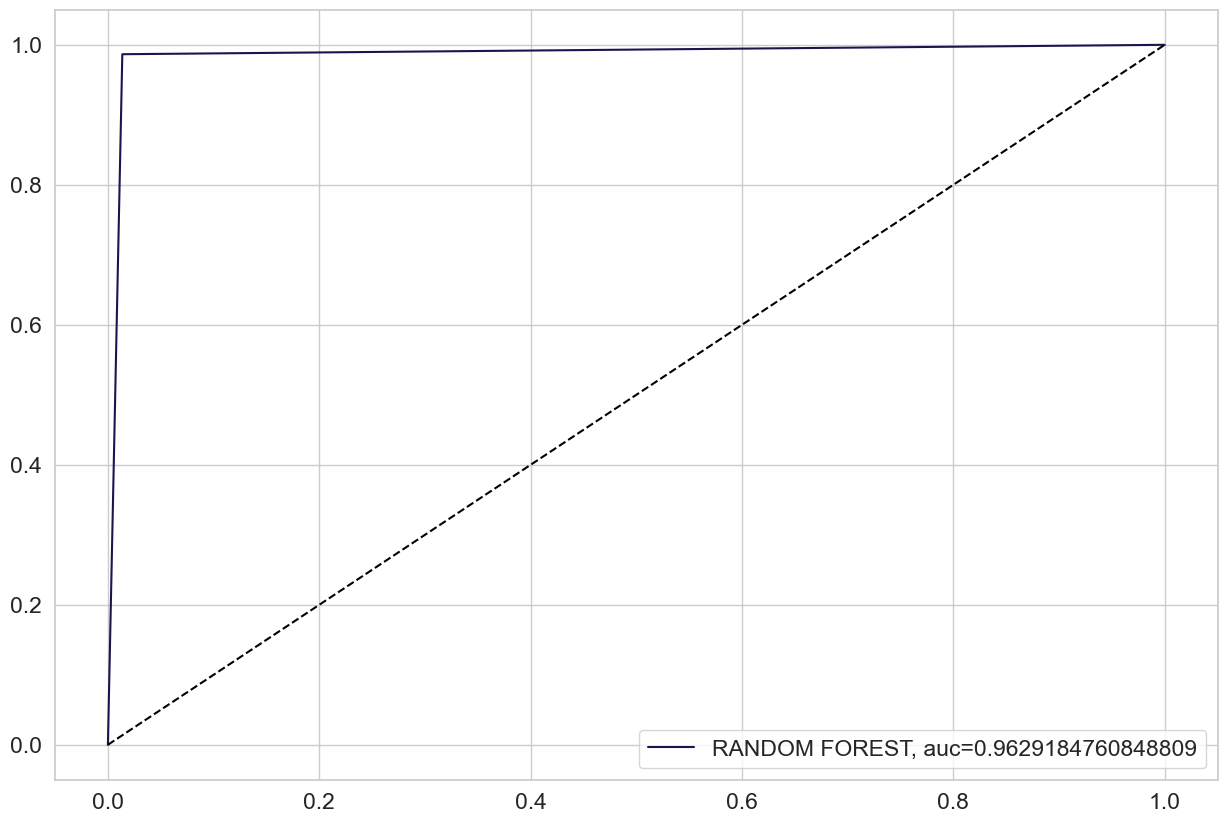

In [38]:
def plot_roc(y, s, name:str):
    """
    y: labels
    s: predictions
    """
    fpr, tpr, thresh = metrics.roc_curve(s, y)
    auc = metrics.roc_auc_score(y, s)
    plt.plot(fpr,tpr,label=f"{name}, auc="+str(auc))


plt.figure(0, figsize=(15,10)).clf()
plot_roc(label, predictions,"RANDOM FOREST")
plt.plot([0, 1], [0, 1], 'k--') #diagonale
plt.legend(loc=0)

# Conclusion
Nous avons une pipeline fonctionnelle capable de classifier l'Attrition en fonction des autres paramètres. On peut maintenant prédire si quelqu'un va avoir tendance a partir ou non, à condition d'avoir les données nécéssaires.

Si on revient sur le grid_search de notre random forest, nous avions triés les variables prises en compte de la plus importantes à la moins importante pour le modèle. On a:
- MeanWorkingHours
- MonthlyIncome
- TotalWorkingYears
- YearsAtCompany
- DistanceFromHome

Ainsi, il va falloir porter attention à ces features. Comme le montre le Graphique ci-dessous:


<img src="./images/graph_features.png">


On peut voir que:
- les salariés qui ont plus tendance a partir font des voyages plus souvent, les voyages ont un impact sur leur équilibre vie privée/professionnelle
- les salariés qui restent longtemps avec le meme manager, ont plus tendance a rester longtemps dans l'entreprise. Il faut donc éviter les changements de manager trop récurrents.

Se concentrer sur ces points peut donc améliorer votre situation, l'utilisation du modèle que nous avons entrainé pourra aussi vous permettre d'établir une stratégie de recrutement.